# Анализ рынка заведений общественного питания Москвы

**Цель исследования**: найти интересные особенности рынка заведений общественного питания Москвы, которые в будущем помогут в выборе подходящего инвесторам места для открытия, предположительно, кофейни.

**Задачи исследования**:


1.   Провести анализ рынка общественного питания в Москве:
2.   Сделать обзор кофеен

**Анализируемые критерии**:


*   категории заведений,
*   количество посадочных мест,
*   соотношение сетевых и несетевых заведений,
*   средние рейтинги заведений,
*   количество заведений (в разрезе районов, улиц),
*   значения средних чеков,
*   часы работы заведений.

<a id="num6"></a>
## Презентация по итогам проведенного анализа

Результаты исследования представлены в презентации

[Ссылка на презентацию (pdf)](<https://drive.google.com/file/d/1oZGuyUqDXmkvyDpu0M8nBLABAPZuHHbI/view?usp=sharing>)

<a id="num1"></a>
## Загрузка данных и подготовка их к анализу

In [ ]:
# Импорт библиотек

import pandas as pd
import numpy as np
import re

from datetime import datetime, timedelta
from math import radians, cos, sin, asin, sqrt

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import json
import folium
# импортируем карту, хороплет и маркер
from folium import Map, Choropleth, Marker
# импортируем кластер
from folium.plugins import MarkerCluster

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# Общие стили
pd.options.display.float_format = '{:.2f}'.format

# Цветовая палитра
# три цвета: основной + подложка, выделение
colors2 = ['#4e1703', '#F1F2F3', '#ffb750']

Посмотрим основную информацию о датасете

In [ ]:
data.head()

name  category                              address  \
0                WoWфли      кафе           Москва, улица Дыбенко, 7/1   
1        Четыре комнаты  ресторан   Москва, улица Дыбенко, 36, корп. 1   
2                 Хазри      кафе       Москва, Клязьминская улица, 15   
3  Dormouse Coffee Shop   кофейня  Москва, улица Маршала Федоренко, 12   
4             Иль Марко  пиццерия      Москва, Правобережная улица, 1Б   

                          district  \
0  Северный административный округ   
1  Северный административный округ   
2  Северный административный округ   
3  Северный административный округ   
4  Северный административный округ   

                                               hours   lat   lng  rating  \
0                             ежедневно, 10:00–22:00 55.88 37.48    5.00   
1                             ежедневно, 10:00–22:00 55.88 37.48    4.50   
2  пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00... 55.89 37.53    4.60   
3                             ежедневно, 09:00–22:00 55.88 37.49    5.00   
4                             ежедневно, 10:00–22:00 55.88 37.45    5.00   

           price                       avg_bill  middle_avg_bill  \
0            NaN                            NaN              NaN   
1  выше среднего       Средний счёт:1500–1600 ₽          1550.00   
2        средние         Средний счёт:от 1000 ₽          1000.00   
3            NaN  Цена чашки капучино:155–185 ₽              NaN   
4        средние         Средний счёт:400–600 ₽           500.00   

   middle_coffee_cup  chain  seats  
0                NaN      0    NaN  
1                NaN      0   4.00  
2                NaN      0  45.00  
3             170.00      0    NaN  
4                NaN      1 148.00

In [ ]:
data.columns # проверим названия столбцов

Index(['name', 'category', 'address', 'district', 'hours', 'lat', 'lng',
       'rating', 'price', 'avg_bill', 'middle_avg_bill', 'middle_coffee_cup',
       'chain', 'seats'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


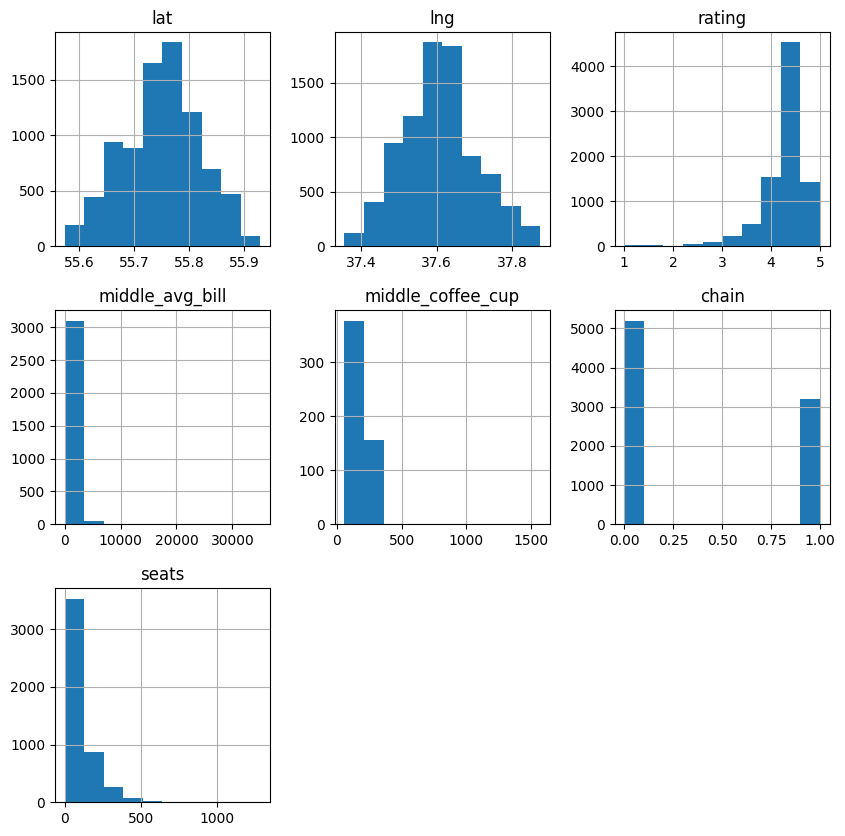

In [ ]:
data.hist(figsize=(10, 10));

Часть столбцов в датасете содержат пропуски и выбросы

In [ ]:
# посчитаем %% пропусков

(data.isna().sum()/data.shape[0]*100).sort_values(ascending=False)

middle_coffee_cup   93.64
middle_avg_bill     62.54
price               60.56
avg_bill            54.60
seats               42.96
hours                6.38
name                 0.00
category             0.00
address              0.00
district             0.00
lat                  0.00
lng                  0.00
rating               0.00
chain                0.00
dtype: float64

Есть столбцы с очень большим процентом пропусков: число с оценкой среднего чека, категория цен в заведении, средняя стоимость заказа в виде диапазона, количество посадочных мест — больше 40% пропусков у 5 из 14 столбцов. По описательным характеристикам — попусков нет. Процент пропусков показателя "число с оценкой одной чашки капучино" (93,64%) не информативен, его надо смотерть у кофеен (оценку проведем далее).

Перейдем к более детальному анализу данных и предобработке.

## Предобработка данных {#num2}

Проверим наличие дубликатов.

In [ ]:
data.duplicated().sum() # проверим, есть ли в датасете явные дубликаты

0

In [ ]:
data[['name', 'address']].duplicated().sum() # дубли по наименованию и адресу

0

In [ ]:
# дубликаты при исправлении регистра по наименованию и адресу
data[['name', 'address']].apply(lambda x: x.str.lower()).duplicated().sum()

4

При игнорировании регистра в наименовании и адресе нашли 4 дублика, посмотрим, что это.

In [ ]:
data[data[['name', 'address']].apply(lambda x: x.str.lower()).duplicated(keep=False)]


name  category  \
189                        Кафе      кафе   
215                        Кафе      кафе   
1430                  More poke  ресторан   
1511                  More Poke  ресторан   
2211  Раковарня Клешни и Хвосты  ресторан   
2420  Раковарня Клешни и хвосты   бар,паб   
3091            Хлеб да Выпечка  булочная   
3109            Хлеб да выпечка      кафе   

                                      address  \
189              Москва, парк Ангарские Пруды   
215              Москва, парк Ангарские пруды   
1430  Москва, Волоколамское шоссе, 11, стр. 2   
1511  Москва, Волоколамское шоссе, 11, стр. 2   
2211               Москва, проспект Мира, 118   
2420               Москва, проспект Мира, 118   
3091              Москва, Ярцевская улица, 19   
3109              Москва, Ярцевская улица, 19   

                                     district  \
189           Северный административный округ   
215           Северный административный округ   
1430          Северный административный округ   
1511          Северный административный округ   
2211  Северо-Восточный административный округ   
2420  Северо-Восточный административный округ   
3091          Западный административный округ   
3109          Западный административный округ   

                                                  hours   lat   lng  rating  \
189                              ежедневно, 09:00–23:00 55.88 37.53    3.20   
215                              ежедневно, 10:00–22:00 55.88 37.53    3.20   
1430                             ежедневно, 09:00–21:00 55.81 37.50    4.20   
1511  пн-чт 09:00–18:00; пт,сб 09:00–21:00; вс 09:00... 55.81 37.50    4.20   
2211                             ежедневно, 12:00–00:00 55.81 37.64    4.40   
2420  пн-чт 12:00–00:00; пт,сб 12:00–01:00; вс 12:00... 55.81 37.64    4.40   
3091                             ежедневно, 09:00–22:00 55.74 37.41    4.10   
3109                                                NaN 55.74 37.41    4.10   

     price avg_bill  middle_avg_bill  middle_coffee_cup  chain  seats  
189    NaN      NaN              NaN                NaN      0    NaN  
215    NaN      NaN              NaN                NaN      0    NaN  
1430   NaN      NaN              NaN                NaN      0 188.00  
1511   NaN      NaN              NaN                NaN      1 188.00  
2211   NaN      NaN              NaN                NaN      0 150.00  
2420   NaN      NaN              NaN                NaN      1 150.00  
3091   NaN      NaN              NaN                NaN      1 276.00  
3109   NaN      NaN              NaN                NaN      0 276.00

Дубликаты возникли, возможно, из-за сбора данных в датасет из разных источников, где заведения оказались немного по-разному указаны (регист букв, разные часы работы). Удалим дубликаты.

In [ ]:
data.loc[data['address'] == 'Москва, парк Ангарские Пруды', 'address'] = \
  'Москва, парк Ангарские пруды'

In [ ]:
data.drop(index=data[data[['name', 'address']].apply(lambda x: x.str.lower())
                                              .duplicated()].index.to_list(),
          inplace=True)

data.shape[0]

8402

Посмотрим дополнительно дубликаты по координатам

In [ ]:
# дубликаты по координатам
data[['lat', 'lng', 'rating']].round(4).duplicated().sum()

50

In [ ]:
# посмотрим дубликаты по более точным координатам
data[data[['lat', 'lng', 'rating']].round(5).duplicated(keep=False)]\
                                   .sort_values(by = 'address').head(10)

name         category  \
1071                                 Кафе  быстрое питание   
1074                  Халяль Кафе-Пекарня         булочная   
2697                   Чайхана Doner кафе             кафе   
2841                        Чайхана Döner             кафе   
2641                                 Янис         ресторан   
2934                             Ресторан         ресторан   
1324             Кафе-кулинария Сикварули         ресторан   
1452                            Сикварули         ресторан   
6142  Кулинарная лавка братьев Караваевых             кафе   
6183                               ДаблБи          кофейня   

                                        address  \
1071      Москва, Анадырский проезд, 8, корп. 1   
1074      Москва, Анадырский проезд, 8, корп. 1   
2697  Москва, Измайловский проспект, 61, стр. 2   
2841        Москва, Измайловский проспект, 61с2   
2641           Москва, Первомайская улица, 116А   
2934           Москва, Первомайская улица, 116А   
1324       Москва, улица Куусинена, 11, корп. 2   
1452       Москва, улица Куусинена, 11, корп. 2   
6142       Москва, улица Шаболовка, 29, корп. 2   
6183       Москва, улица Шаболовка, 29, корп. 2   

                                     district  \
1071  Северо-Восточный административный округ   
1074  Северо-Восточный административный округ   
2697         Восточный административный округ   
2841         Восточный административный округ   
2641         Восточный административный округ   
2934         Восточный административный округ   
1324          Северный административный округ   
1452          Северный административный округ   
6142       Центральный административный округ   
6183       Центральный административный округ   

                                     hours   lat   lng  rating    price  \
1071                                   NaN 55.86 37.68    3.70      NaN   
1074                ежедневно, 08:00–21:00 55.86 37.68    3.70      NaN   
2697              ежедневно, круглосуточно 55.79 37.78    4.00      NaN   
2841              ежедневно, круглосуточно 55.79 37.78    4.00      NaN   
2641                ежедневно, 12:00–00:00 55.79 37.82    4.30  высокие   
2934                                   NaN 55.79 37.82    4.30      NaN   
1324                ежедневно, 10:00–22:00 55.78 37.51    4.40      NaN   
1452                ежедневно, 10:00–22:00 55.78 37.51    4.40      NaN   
6142                ежедневно, 08:00–23:00 55.72 37.61    4.30      NaN   
6183  пн-пт 08:00–20:00; сб,вс 10:00–20:00 55.72 37.61    4.30      NaN   

                     avg_bill  middle_avg_bill  middle_coffee_cup  chain  \
1071                      NaN              NaN                NaN      0   
1074   Средний счёт:300–700 ₽           500.00                NaN      0   
2697                      NaN              NaN                NaN      0   
2841                      NaN              NaN                NaN      0   
2641  Средний счёт:500–3000 ₽          1750.00                NaN      0   
2934                      NaN              NaN                NaN      0   
1324                      NaN              NaN                NaN      0   
1452                      NaN              NaN                NaN      1   
6142                      NaN              NaN                NaN      1   
6183                      NaN              NaN                NaN      1   

      seats  
1071 100.00  
1074 100.00  
2697  15.00  
2841    NaN  
2641  40.00  
2934  40.00  
1324  10.00  
1452  10.00  
6142 130.00  
6183 130.00

Из-за разного написания наименований в датасете попадаются дубликаты (удалены 4).

Дубликаты возникли, скорее всего, из-за сбора данных из разных источников, где заведения оказались немного по-разному указаны. Например, разное написание наименований: Сикварули / Кафе-кулинария Сикварули, Чайхана Doner кафе / Чайхана Döner.

Для полной обработки и выявления максмимального количества дубликатов необходимо учесть написание латиница / кириллица, частичную схожесть написания наименований. Однако проделанная работа с датасетом показала, что дубликаты — скорее, единичные и существенной проблемы не создают, оставим как есть.

Проведем предобработку по столбцам.

In [ ]:
# Объявим функцию для удобства анализа пропусков по столбцам
def count_missed(col: str):
  '''
  Функция принимает наименования столбца для анализа
  Выводит %% пропусков и кол-во заполненных значений (всего и по кофейням)
  '''

  # сколько пропусков
  print('Процент пропусков:\nвсего — {:.2%}, кофейни  — {:.2%}'\
        .format(data[col].isna().sum() / data.shape[0],
                data.query('category == "кофейня"')[col].isna().sum() /
                data.query('category == "кофейня"').shape[0]))

  # сколько данных без пропусков
  print('\nКоличество строк (заведений) с заполненными данными:\n'
        'всего — {:.0f}, кофейни  — {:.0f}'\
        .format(data[~data[col].isna()].shape[0],
                data[~data[col].isna()].query('category == "кофейня"')[col]
                                       .shape[0]))

### Столбец `adress` — адрес

Пропусков нет. Посмотрим, как заведены адреса, добавим столбец с улицей.

In [ ]:
# смотрим, как указаны адреса
data['address'].sample(15)

5901           Москва, улица Дмитрия Ульянова, 24/1
5395             Москва, Рязанский проспект, 2/1к2Б
6074    Москва, Ломоносовский проспект, 25, корп. 2
2818                  Москва, Суворовская улица, 24
1322            Москва, проезд Аэропорта, 8, стр. 9
3435       Москва, Большая Грузинская улица, 2/12с1
4075               Москва, Болотная набережная, 7с3
4438                      Москва, улица Покровка, 6
7897                 Москва, Ореховый бульвар, 14к3
7634         Москва, Чертановская улица, 32, стр. 3
7181           Москва, Каширский проезд, 9, корп. 1
8065    Москва, 2-й Южнопортовый проезд, 18, стр. 8
6326            Москва, 3-й Автозаводский проезд, 4
2686                 Москва, Первомайская улица, 52
4387        Москва, Дурасовский переулок, 1, стр. 1
Name: address, dtype: object

In [ ]:
# проверим, не попали ли в датасет заведения не из Мск

data[~data['address'].str.contains(r'\bМосква')]

Empty DataFrame
Columns: [name, category, address, district, hours, lat, lng, rating, price, avg_bill, middle_avg_bill, middle_coffee_cup, chain, seats]
Index: []

Выделим улицы в отдельный столбец

In [ ]:
# Т.к. данные из Я.Карт и Я.Бизнес, то
# адреса, скорее всего, содержат стандартные наименования
# Возьмем распространенные наименования из 5-го уровня КЛАДР

words = ['аллея', 'бульвар', 'въезд', 'городок', 'дорога', 'заезд', 'казарма',
         'квартал', 'километр', 'кольцо', 'линия', 'набережная', 'остров',
         'парк', 'переезд', 'переулок', 'район', 'платформа', 'площадь',
         'проезд', 'проспект', 'разъезд', 'сквер', 'станция', 'тракт', 'тупик',
         'улица', 'участок',  'шоссе', 'заказник', 'просек', 'тоннель',
         'заказник', 'памятник', 'сад', 'мост', 'музей-заповедник']

# Воспользуемся регулярным выражением, чтобы выделить улицы и т.д.
# по ключевому слову из words
str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*),?".format("|".join(words))

data['street'] = data['address'].str.extract(str_pat, flags=re.I)

data[['address', 'street']].head(10)

address                   street
0               Москва, улица Дыбенко, 7/1            улица Дыбенко
1       Москва, улица Дыбенко, 36, корп. 1            улица Дыбенко
2           Москва, Клязьминская улица, 15       Клязьминская улица
3      Москва, улица Маршала Федоренко, 12  улица Маршала Федоренко
4          Москва, Правобережная улица, 1Б      Правобережная улица
5             Москва, Ижорская улица, вл8Б           Ижорская улица
6    Москва, Клязьминская улица, 9, стр. 3       Клязьминская улица
7    Москва, Клязьминская улица, 9, стр. 3       Клязьминская улица
8  Москва, Дмитровское шоссе, 107, корп. 4        Дмитровское шоссе
9              Москва, Ангарская улица, 39          Ангарская улица

In [ ]:
# Проверим полноту заполнения улиц
data['street'].isna().sum()
data[data['street'].isna()]['address']

# Результат первой обработки - 30 пропусков, дополним словарь ключевых слов
# и проверим повторно

data[data['street'].isna()]['address']

2495    Москва, ул. Ярославская, 8, корп. 1
6276       Москва, пр-т Комсомольский, д.28
6309                            Москва, № 7
6847         Москва, ул. Профсоюзная, д.104
7766                  Москва, Сумская, 2/12
Name: address, dtype: object

Адреса пяти объектов в датасете заведены некорреткно. Проверим, как в датасете указаны такие улицы, исправим написание и проведем обработку.

In [ ]:
data[data['address'].str.contains(r'\bЯрославская')]['street'].unique()

array(['Ярославская улица', nan], dtype=object)

In [ ]:
data[data['address'].str.contains(r'\bКомсомольский')]['street'].unique()

array(['Комсомольский проспект', nan], dtype=object)

In [ ]:
data[data['address'].str.contains(r'\bПрофсоюзная')]['street'].unique()

array(['Профсоюзная улица', nan], dtype=object)

In [ ]:
data[data['address'].str.contains(r'\bСумская')]['street'].unique()

array([nan], dtype=object)

In [ ]:
# поскольку значений немного, обработаем их отдельно
data['address'] = data['address'].str.replace('ул. Ярославская',
                                              'Ярославская улица', regex=True)
data['address'] = data['address'].str.replace('пр-т Комсомольский',
                                              'Комсомольский проспект',
                                              regex=True)
data['address'] = data['address'].str.replace('ул. Профсоюзная',
                                              'Профсоюзная улица', regex=True)
data['address'] = data['address'].str.replace('Сумская',
                                              'Сумская улица', regex=True)

data['street'] = data['address'].str.extract(str_pat, flags=re.I)

# на Я.Картах у заведения 'Москва, № 7' не указана улица, оставим как есть
data['street'] = data['street'].fillna('нет улицы')

In [ ]:
data[data['street'].isna()]

Empty DataFrame
Columns: [name, category, address, district, hours, lat, lng, rating, price, avg_bill, middle_avg_bill, middle_coffee_cup, chain, seats, street]
Index: []

In [ ]:
# Проверим, нет ли повторения улиц из-за разного регистра
list = [x.lower() for x in data['street'].unique()]
[x for i, x in enumerate(list) if x in list[:i]]

[]

###Столбец `hours` — часы работы

In [ ]:
count_missed('hours') # функция подсчета пропусков

Процент пропусков:
всего — 6.37%, кофейни  — 1.06%

Количество строк (заведений) с заполненными данными:
всего — 7867, кофейни  — 1398


Заменить пропуски на релевантные значения на основе данных датасета невозможно. Поскольку пропусков менее 7% всего и 1% в интересующих нас детально кофейнях, оставим пропуски, как есть.

**Создадим столбец is_24/7** с обозначением, что заведение работает ежедневно и круглосуточно (24/7): True — если заведение работает ежедневно и круглосуточно; False — в противоположном случае (если информация отсутствует — также будет указано False, чтобы столбец был с булевыми значениями; отфильтровать по заполненным данным мы можем по столбцу `hours`).


In [ ]:
data['is_24/7'] = False
data['is_24/7'] = data['hours'].str.contains('ежедневно, круглосуточно')
data['is_24/7'] = data['is_24/7'].fillna(False)
data['is_24/7'] = data['is_24/7'].astype('bool')

In [ ]:
# посмотрим, как заполнен столбец
data['hours'].sample(10)

125                                ежедневно, 11:00–23:00
5495                 пн-пт 11:00–19:00; сб,вс 10:00–20:00
1428                 пн-пт 08:00–22:00; сб,вс 09:00–22:00
501                                ежедневно, 10:00–22:00
1082                                                  NaN
5687                    пн-чт 08:00–19:00; пт 08:00–18:00
3393                               ежедневно, 12:00–23:00
4926                               ежедневно, 12:00–00:00
4992                 пн-пт 11:00–00:00; сб,вс 12:00–00:00
3760    пн-чт 11:00–23:00; пт,сб 11:00–00:00; вс 11:00...
Name: hours, dtype: object

In [ ]:
# самые короткие строки
data.loc[data[~data['hours'].isna()]['hours'].str.len().sort_values()
                                                       .head(10).index, 'hours']

592        пн 10:00–20:00
4152       пт 15:00–17:00
5299       Нет информации
7858       ср 08:00–20:00
1132     сб круглосуточно
1497    пн-пт 08:00–19:30
4290    пн-пт 09:00–18:00
4293    пн-пт 08:30–19:00
4299    пн-пт 08:00–18:30
4304    пн-пт 08:30–20:00
Name: hours, dtype: object

In [ ]:
# заменим "Нет информации" на nan
data['hours'] = data['hours'].replace('Нет информации', np.nan)

In [ ]:
# самые длинные строки
pd.set_option('display.max_colwidth', None) # отобразим полностью
data.loc[data[~data['hours'].isna()]['hours'].str.len().sort_values()
                                                       .tail(5).index, 'hours']

3732                            пн,вт 08:00–22:00; ср,чт 08:00–23:00; пт,сб круглосуточно; вс 00:00–22:00
1942                  пн круглосуточно; вт-чт 12:00–00:00; пт 12:00–02:00; сб 11:00–02:00; вс 14:00–00:00
3531             пн-чт круглосуточно; пт 00:00–05:00, перерыв 05:00–07:00; сб 07:00–05:00; вс 07:00–00:00
699           пн 00:01–12:00, перерыв 12:00–13:30; вт-чт 13:30–12:00; пт 13:30–00:00; сб,вс круглосуточно
7864    пн 10:30–04:00; вт 11:00–03:00; ср 10:30–03:00; чт 10:00–03:00; пт,сб 11:00–04:00; вс 10:30–04:00
Name: hours, dtype: object

Чтобы можно было проанализировать режим работы заведений в течение недели, внесем информацию о начале и окончании работы в отдельные столбцы по дням недели.

In [ ]:
def hour_list(row):
  '''
  Функция возвращает строку с часами работы для каждого дня недели
  '''
  week = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']

  if pd.isna(row): # пустоты оставляем как nan и не обрабатываем
    return row
  else:
    # заменим круглосуточно и ежедневно на дни недели и часы работы
    row = row.replace('ежедневно, круглосуточно',
                      'пн,вт,ср,чт,пт,сб,вс 00:00–24:00')
    row = row.replace('ежедневно,', 'пн,вт,ср,чт,пт,сб,вс')
    row = row.replace('круглосуточно', '00:00–24:00')

    # разделим строку на части
    df = []
    df = row.split('; ')

    # приведем все части к единому виду:
    # периоды через "-" укажем как перечень дней недели через запятую
    for i in range(len(df)):
      #удалим информацию о перерывах
      if df[i].count("перерыв"):
        df[i] = df[i].split(", ")[0]

      part_df = df[i].split()
      if part_df[0].count("-"):
        part_df[0] = ','.join(week[week.index(part_df[0].split('-')[0]):\
                                   week.index(part_df[0].split('-')[1])+1])
        df[i] = f'{part_df[0]} {part_df[1]}'

    # для каждого указанного дня недели отдельно укажем время
    df_new = []
    for i in range(len(df)):
      part_new = []
      part_df = df[i].split()
      if part_df[0].count(","):
        part_new = part_df[0].split(',')
        part_new[:] = [f'{w} {part_df[1]}' for w in part_new]
        df_new.extend(part_new)
      else:
        df_new.append(df[i])

    # добавим информацию о пропущенных днях неделях
    for i in range(7):
      try:
        if not df_new[i].count(week[i]):
          df_new.insert(i, f'{week[i]} нд–нд')
      except:
        df_new.insert(i, f'{week[i]} нд–нд')

    # вернем информацию только о часах работы одной строкой через "–"
    return re.sub("(пн |вт |ср |чт |пт |сб |вс )","", "–".join(df_new))


In [ ]:
data['hour_list']= data['hours'].apply(hour_list)

In [ ]:
# проверим корректно ли заполнены значения
# кол-во данных о часах работы: мин и макс должны быть равны 14
data[~data['hour_list'].isna()]['hour_list'].str.split("–")\
                                   .apply(lambda x: len(x)).agg(['min', 'max'])

min    14
max    14
Name: hour_list, dtype: int64

In [ ]:
# заполним данные о начале и конце работы заведений в столбцы по дням недели
data[['mo_start', 'mo_end',
      'tu_start', 'tu_end',
      'we_start', 'we_end',
      'th_start', 'th_end',
      'fr_start', 'fr_end',
      'sa_start', 'sa_end',
      'su_start', 'su_end']] = pd.DataFrame(data['hour_list']\
                                .str.split("–",expand=True), index = data.index)

data.drop(columns='hour_list', axis=1 , inplace=True)

In [ ]:
# введем переменную с перечнем столбцов о начале и конце работы заведений
# (для удобства фильтров)
list_day_start_off = ['mo_start', 'mo_end',
                      'tu_start', 'tu_end',
                      'we_start', 'we_end',
                      'th_start', 'th_end',
                      'fr_start', 'fr_end',
                      'sa_start', 'sa_end',
                      'su_start', 'su_end']

In [ ]:
# результат
data[list_day_start_off].sample(5)

mo_start mo_end tu_start tu_end we_start we_end th_start th_end fr_start  \
7643    08:00  22:00    08:00  22:00    08:00  22:00    08:00  22:00    08:00   
3049    11:00  20:00    11:00  20:00    11:00  20:00    11:00  20:00    11:00   
3780    15:00  00:00    15:00  00:00    15:00  00:00    15:00  05:00    15:00   
8218    10:00  18:00    10:00  18:00    10:00  18:00    10:00  18:00    10:00   
6555    10:00  01:00    10:00  01:00    10:00  01:00    10:00  01:00    10:00   

     fr_end sa_start sa_end su_start su_end  
7643  22:00    09:00  21:00    09:00  21:00  
3049  20:00    11:00  20:00    11:00  20:00  
3780  05:00    15:00  05:00    13:00  05:00  
8218  18:00       нд     нд       нд     нд  
6555  01:00    10:00  01:00    10:00  01:00

In [ ]:
# "нд" заменим на nan
data[list_day_start_off] = data[list_day_start_off].replace('нд', np.nan)

In [ ]:
# откорректируем время закрытия: изменим 00:00 на 24:00, чтобы избежать путаницы
data[['mo_end','tu_end','we_end',
      'th_end','fr_end','sa_end','su_end']] = data[['mo_end','tu_end','we_end',
                                                    'th_end','fr_end','sa_end',
                                                    'su_end']]\
                                                  .replace(['00:00'], ['24:00'])

# перевод в формат даты оказался неудобен для анализа, поэтому
# переведем данные в часы, сколько времени прошло от 00:00
for col in list_day_start_off:
    data[col] = data[col].apply(lambda x: x if pd.isna(x)
                                            else int(x.split(":")[0])+\
                                                 int(x.split(":")[1])/60)

In [ ]:
# Результат
data[list_day_start_off].sample(5)

mo_start  mo_end  tu_start  tu_end  we_start  we_end  th_start  th_end  \
705       9.00   17.00      9.00   17.00      9.00   17.00      9.00   17.00   
2749      8.00   22.00      8.00   22.00      8.00   22.00      8.00   22.00   
6703      9.00   18.00      9.00   18.00      9.00   18.00      9.00   18.00   
67       12.50   24.00     12.50   24.00     12.50   24.00     12.50   24.00   
5107     11.00   24.00     11.00   24.00     11.00   24.00     11.00   24.00   

      fr_start  fr_end  sa_start  sa_end  su_start  su_end  
705       9.00   17.00       NaN     NaN       NaN     NaN  
2749      8.00   22.00      8.00   22.00      8.00   22.00  
6703      9.00   18.00     10.00   18.00     10.00   18.00  
67       12.50    2.00     12.50    2.00     12.50   24.00  
5107     11.00   24.00     12.00   24.00     12.00   24.00

### Столбцы с данными о ценах: `avg_bill`, `middle_avg_bill`, `middle_coffee_cup`, `price`.

**Средняя стоимость заказа в виде диапазона**

In [ ]:
# посмотрим, как указан показатель
data['avg_bill'].sample(10)

7433                              NaN
3599         Средний счёт:1300–2000 ₽
3992           Средний счёт:130–700 ₽
7186                              NaN
5716    Цена чашки капучино:200–250 ₽
8331          Средний счёт:500–1500 ₽
301          Средний счёт:1000–2000 ₽
2861                              NaN
1753                              NaN
6759                              NaN
Name: avg_bill, dtype: object

In [ ]:
data['avg_bill'].nunique()

897

Уникальных значений много, нет смысла их дополнительно анализировать, т.к. в датасете есть столбцы с обработанными данными.

**Средний счет**

In [ ]:
# средний счет
data['middle_avg_bill'].sample(10)

3143       NaN
1048       NaN
773     600.00
6970       NaN
5788       NaN
5708       NaN
3503   1700.00
1548       NaN
3643       NaN
5685   1250.00
Name: middle_avg_bill, dtype: float64

In [ ]:
data['middle_avg_bill'].describe()

count    3149.00
mean      958.05
std      1009.73
min         0.00
25%       375.00
50%       750.00
75%      1250.00
max     35000.00
Name: middle_avg_bill, dtype: float64

В данных есть выбросы

In [ ]:
# проверим полноту заполнения
data[data['avg_bill'].str.replace('ё', 'е')
                     .str.lower()
                     .str.contains(r'\bcредний счет')
     & data['middle_avg_bill'].isna()]['avg_bill']

Series([], Name: avg_bill, dtype: object)

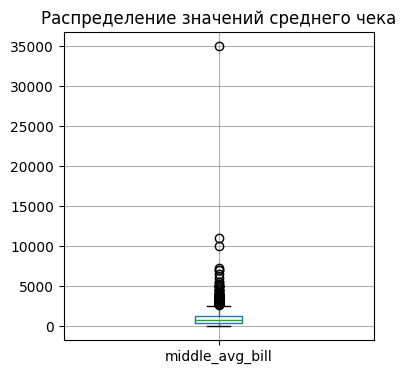

In [ ]:
# посмотрим как распределены значения

fig = plt.figure(figsize=(4, 4))
data.boxplot(column='middle_avg_bill')
plt.title('Распределение значений среднего чека')
plt.show;

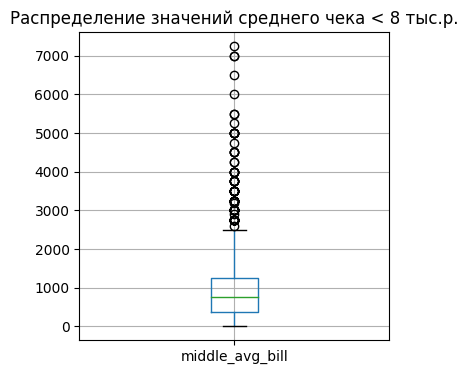

In [ ]:
fig = plt.figure(figsize=(4, 4))
data[data['middle_avg_bill']<8000].boxplot(column='middle_avg_bill')
plt.title('Распределение значений среднего чека < 8 тыс.р.')
plt.show;

In [ ]:
# проверим, нет ли ошибки в расчетах у аномальных значений выше 8 т.р.
data[data['middle_avg_bill']>8000][['name', 'category', 'address',
                                    'avg_bill','middle_avg_bill']]

name  category                              address  \
730   Чойхона   бар,паб       Москва, Дмитровское шоссе, 95А   
5481    Гости  ресторан        Москва, шоссе Энтузиастов, 52   
7177     Кафе  ресторан  Москва, Каширское шоссе, 23, стр. 2   

                        avg_bill  middle_avg_bill  
730    Средний счёт:5000–17000 ₽         11000.00  
5481   Средний счёт:5000–15000 ₽         10000.00  
7177  Средний счёт:20000–50000 ₽         35000.00

В указанных данных (в avg_bill) не исключены ошибки, но с уверенностью утверждать, что все высокие значения показателя — неверные, мы не можем.

 Посчитаем выборочные перцентили.

In [ ]:
np.percentile(data[~data['middle_avg_bill'].isna()]['middle_avg_bill'],
              [90, 95, 99])

array([2000., 2250., 3750.])

Не более 5% заведений с заполненными данными имеют средний чек выше 2250.

Проверим, как влияют аномально высокие значения на медиану

In [ ]:
data['middle_avg_bill'].median() # медиана по всем данным

750.0

In [ ]:
# медиана без 1% аномальны высоких
data[data['middle_avg_bill']<3750]['middle_avg_bill'].median()

700.0

In [ ]:
# медиана без всех выбросов (5%)
data[data['middle_avg_bill']<2250]['middle_avg_bill'].median()

650.0

За выбросы можно принять значения выше 2250 (5% заполненных данных). Средний счет (медианное значение) без учета выбросов на 100 р. меньше (-13%). Удалять аномально высокие значения не будем (не можем быть уверены, что это ошибки, а не дорогие заведения), но при анализе наличие аномалий и их влияние — необходимо учесть.

In [ ]:
# переменная для удобства фильтрации аномалий по среднему чеку
filter_bill = 'middle_avg_bill <= 2250'

**Средняя цена одной чашки капучино**

In [ ]:
data[~data['middle_coffee_cup'].isna()]['middle_coffee_cup'].sample(10)

7779   129.00
6943    95.00
1350   135.00
408    175.00
8031   110.00
1757   190.00
6984   160.00
4556   275.00
2537   110.00
6145   210.00
Name: middle_coffee_cup, dtype: float64

In [ ]:
count_missed('middle_coffee_cup') # функция подсчета пропусков

Процент пропусков:
всего — 93.63%, кофейни  — 63.13%

Количество строк (заведений) с заполненными данными:
всего — 535, кофейни  — 521


In [ ]:
# проверим полноту заполнения
data[data['avg_bill'].str.replace('ё', 'е')
                     .str.lower()
                     .str.contains(r'\bкапучин')
     & data['middle_coffee_cup'].isna()]['avg_bill']

Series([], Name: avg_bill, dtype: object)

Процент пропусков по отношению к общему числу заведений не информативен, но у кофеен он также значителен — 63,13%. Данные заполнены у 521 кофейни и еще у нескольких заведений (14) из других категорий.
Восстановить значения невозможно, пропуски оставлены, как есть.

In [ ]:
data['middle_coffee_cup'].describe()

count    535.00
mean     174.72
std       88.95
min       60.00
25%      124.50
50%      169.00
75%      225.00
max     1568.00
Name: middle_coffee_cup, dtype: float64

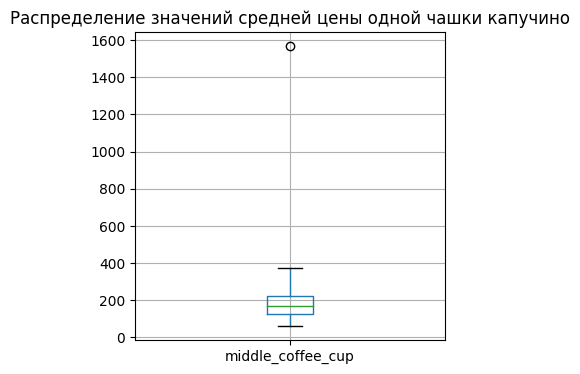

In [ ]:
# посмотрим как распределены значения

fig = plt.figure(figsize=(4, 4))
data.boxplot(column='middle_coffee_cup')
plt.title('Распределение значений средней цены одной чашки капучино')
plt.show;

In [ ]:
# проверим, нет ли ошибки в расчетах у аномального значения
data[data['middle_coffee_cup']>1400][['name','avg_bill','middle_coffee_cup']]

name                        avg_bill  middle_coffee_cup
2859  Шоколадница  Цена чашки капучино:230–2907 ₽            1568.00

В данных, скорее всего, опечатка и максимальная стоимость 290 р. Исправим среднюю стоимость капучино в Шоколаднице на 260 р.

In [ ]:
data.loc[data['middle_coffee_cup']>1400, ['avg_bill','middle_coffee_cup']] = ['Цена чашки капучино:230–290 ₽', 260]

In [ ]:
data['middle_coffee_cup'].describe()

count   535.00
mean    172.28
std      65.46
min      60.00
25%     124.50
50%     169.00
75%     225.00
max     375.00
Name: middle_coffee_cup, dtype: float64

**Категории цен в заведении**

In [ ]:
# посмотрим значения
data['price'].unique()

array([nan, 'выше среднего', 'средние', 'высокие', 'низкие'], dtype=object)

In [ ]:
count_missed('price') # функция подсчета пропусков

Процент пропусков:
всего — 60.55%, кофейни  — 66.31%

Количество строк (заведений) с заполненными данными:
всего — 3315, кофейни  — 476


Пропусков довольно много и по всем заведениям (60,6%), и по кофейням (66,3%). Посмотрим, есть ли соответствие между данными о среднем чеке и категорией.

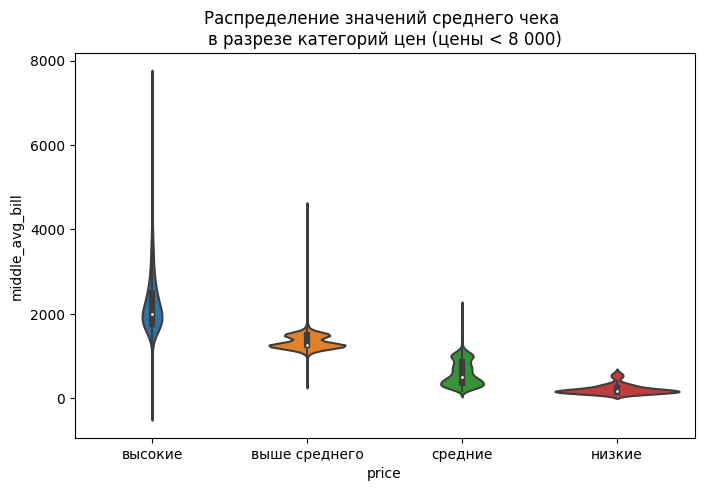

In [ ]:
fig = plt.figure(figsize=(8, 5))
sns.violinplot(x='price',
               y='middle_avg_bill',
               data=data[data['middle_avg_bill']<8000],
               order = ['высокие', 'выше среднего', 'средние', 'низкие'])
plt.title('Распределение значений среднего чека \n'+
          'в разрезе категорий цен (цены < 8 000)')
plt.show;

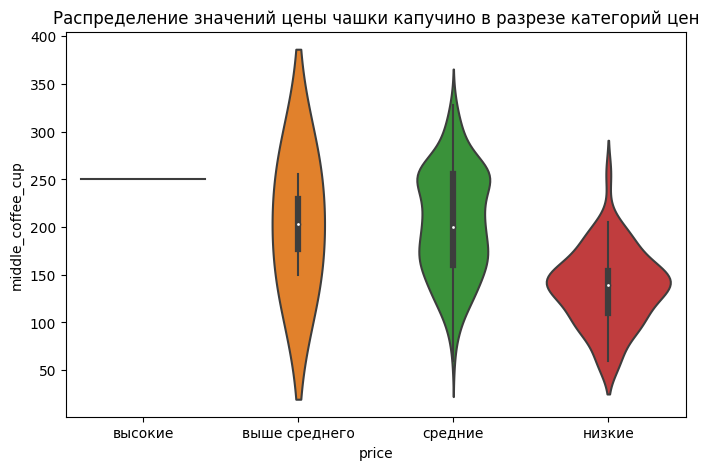

In [ ]:
fig = plt.figure(figsize=(8, 5))
sns.violinplot(x='price', y='middle_coffee_cup', data=data,
               order = ['высокие', 'выше среднего', 'средние', 'низкие'])
plt.title('Распределение значений цены чашки капучино \nв разрезе категорий цен')
plt.show;

Данные в датасете из сервиса Яндекс Бизнес, могли быть добавлены пользователями или найдены в общедоступных источниках. Категории цен, скорее, отражают субъективное восприятие посетителей, четкой градации нет. Заполнять пропуски в категории цен — не имеет смысла, оставим, как есть.

### Столбец `seats` — количество посадочных мест

In [ ]:
count_missed('seats') # функция подсчета пропусков

Процент пропусков:
всего — 42.97%, кофейни  — 46.85%

Количество строк (заведений) с заполненными данными:
всего — 4792, кофейни  — 751


Это значительный объем пропусков, но заменить пропуски на релевантные значения на основе данных датасета невозможно, оставим, как есть.


In [ ]:
data['seats'].describe()

count   4792.00
mean     108.36
std      122.84
min        0.00
25%       40.00
50%       75.00
75%      140.00
max     1288.00
Name: seats, dtype: float64

В данных есть выбросы

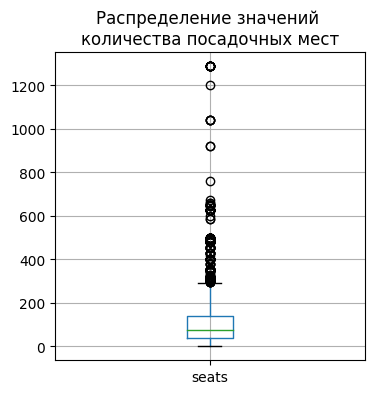

In [ ]:
# посмотрим как распределены значения

fig = plt.figure(figsize=(4, 4))
data.boxplot(column='seats')
plt.title('Распределение значений \nколичества посадочных мест')
plt.show;

In [ ]:
# посмотрим, к каким категориям относятся заведения с аномальным кол-вом мест
data[data['seats']>500].groupby('category')['seats'].mean()

category
бар,паб            834.10
булочная           625.00
быстрое питание   1040.00
кафе               780.36
кофейня            774.25
пиццерия           790.75
ресторан           853.83
столовая           912.50
Name: seats, dtype: float64

 Посчитаем выборочные перцентили количества посадочных мест.

In [ ]:
np.percentile(data[~data['seats'].isna()]['seats'], [90, 95, 99])

array([240., 307., 625.])

Не более 5% заведений с заполненными данными имеют больше 307 посадочных мест; по 1% заведений указано кол-во мест более 625. С аномально большим кол-вом мест (более 500) есть в том числе заведения из категорий булочная, кафе, кофейня — данные, скорее всего, некорректные.
Примем за аномалии количество посадочных мест более 307 (5% заполненных данных) и заменим такие значения на nan.

In [ ]:
data.loc[data['seats']>307, 'seats'] = np.nan

In [ ]:
data['seats'].describe()

count   4553.00
mean      88.27
std       71.06
min        0.00
25%       40.00
50%       70.00
75%      120.00
max      307.00
Name: seats, dtype: float64

In [ ]:
count_missed('seats') # функция подсчета пропусков

Процент пропусков:
всего — 45.81%, кофейни  — 49.61%

Количество строк (заведений) с заполненными данными:
всего — 4553, кофейни  — 712


После удаления аномальных значений кол-во заполненных данных сократилось на 5 п.п., по кофейням меньше — на 2,82 п.п. Количество строк с заполненными данными по кофейням — 712 (50,39%).

### Другие столбцы датасета

In [ ]:
data['name'].nunique() #сколько уникальных наименований

5613

In [ ]:
# проверим корректность наименований категорий
data['category'].unique()

array(['кафе', 'ресторан', 'кофейня', 'пиццерия', 'бар,паб',
       'быстрое питание', 'булочная', 'столовая'], dtype=object)

In [ ]:
# проверим корректность указания рейтингов
data['rating'].unique()

array([5. , 4.5, 4.6, 4.4, 4.7, 4.8, 4.3, 4.9, 4.2, 4.1, 4. , 3.8, 3.9,
       3.7, 3.6, 2.8, 2.7, 3.1, 1.5, 2. , 1.4, 3.3, 3.5, 3.2, 2.9, 3. ,
       3.4, 2.3, 2.2, 2.5, 2.6, 1.7, 1. , 1.1, 2.4, 1.3, 1.2, 2.1, 1.8,
       1.9, 1.6])

In [ ]:
data['rating'].describe()

count   8402.00
mean       4.23
std        0.47
min        1.00
25%        4.10
50%        4.30
75%        4.40
max        5.00
Name: rating, dtype: float64

In [ ]:
# проверим заполнение признака "сетевые / несетевые"
data['chain'].unique()

array([0, 1])

In [ ]:
data['chain'] = data['chain'].astype('bool') # изменим типа столбца

In [ ]:
# проверим заполнение округов
data['district'].unique()

array(['Северный административный округ',
       'Северо-Восточный административный округ',
       'Северо-Западный административный округ',
       'Западный административный округ',
       'Центральный административный округ',
       'Восточный административный округ',
       'Юго-Восточный административный округ',
       'Южный административный округ',
       'Юго-Западный административный округ'], dtype=object)

In [ ]:
#добавим сокращенное наименование округов
data['dist'] = data['district'].replace(['Северный административный округ',
                                        'Северо-Восточный административный округ',
                                        'Северо-Западный административный округ',
                                        'Западный административный округ',
                                        'Центральный административный округ',
                                        'Восточный административный округ',
                                        'Юго-Восточный административный округ',
                                        'Южный административный округ',
                                        'Юго-Западный административный округ'],
                                        ['САО',
                                        'СВАО',
                                        'СЗАО',
                                        'ЗАО',
                                        'ЦАО',
                                        'ВАО',
                                        'ЮВАО',
                                        'ЮАО',
                                        'ЮЗАО'])

In [ ]:
data['dist'].unique()

array(['САО', 'СВАО', 'СЗАО', 'ЗАО', 'ЦАО', 'ВАО', 'ЮВАО', 'ЮАО', 'ЮЗАО'],
      dtype=object)

In [ ]:
# итоги
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8402 entries, 0 to 8405
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8402 non-null   object 
 1   category           8402 non-null   object 
 2   address            8402 non-null   object 
 3   district           8402 non-null   object 
 4   hours              7866 non-null   object 
 5   lat                8402 non-null   float64
 6   lng                8402 non-null   float64
 7   rating             8402 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8402 non-null   bool   
 13  seats              4553 non-null   float64
 14  street             8402 non-null   object 
 15  is_24/7            8402 non-null   bool   
 16  mo_start           7793 

### Итоги предобработки

* **Дубликаты**. Явных дубликатов в датасете нет. Неявные — проверены по совпадению наименований и адресов (при приведении данных к единому регистру), по совпадению координат (с точностью до 4 знаков после запятой) и рейтину. Удалены 4 дубликата.

 Дубликаты возникли, скорее всего, из-за сбора данных в датасет из разных источников, где заведения оказались немного по-разному указаны. Например, разное написание наименований: Сикварули / Кафе-кулинария Сикварули, Чайхана Doner кафе / Чайхана Döner.

 Для полной обработки дубликатов необходимо учесть написание латиница / кириллица, частичную схожесть написания наименований. Однако проделанная работа с датасетом показала, что дубликаты — скорее, единичные и существенной проблемы не создают.

* **Пропуски**. Есть столбцы с очень большим процентом пропусков: число с оценкой среднего чека (62,5%), категория цен в заведении (60,6%), средняя стоимость заказа в виде диапазона (54,6%), количество посадочных мест (43%). Процент пропусков показателя "число с оценкой одной чашки капучино" по отношению к общему числу заведений — 93,64%, т.к. характеристика относится к кофейням, но у кофеен он также значителен — 63,13%. — Итого больше 40% пропусков у 5 из 14 столбцов. По другим характеристикам попусков нет.
Качественно восстановить значения на основе данных датасета невозможно. Пропуски оставлены, как есть.

* **Аномальные значения**:
 - количество посадочных мест — не более 5% заведений с заполненными данными имеют больше 307 посадочных мест. С аномально большим кол-вом мест (более 500) есть в том числе заведения из категорий булочная, кафе, кофейня — данные, скорее всего, некорректные. За аномалии принято количество посадочных мест более 307 (5% заполненных данных), значения заменены на nan. После удаления аномальных значений кол-во заполненных данных сократилось на 5 п.п., по кофейням меньше — на 2,82 п.п.
 - средний чек — за выбросы можно принять значения выше 2250 (5% заполненных данных). Значения не удалены, т.к. не можем быть уверены, что это ошибки, а не дорогие заведения. При этом средний счет (медианное значение) без учета выбросов на 100 р. меньше (-13%). При анализе наличие аномалий и их влияние — необходимо учесть. Для фильтра создала переменная `filter_bill` (строка, для использования в query)
 - средняя цена одной чашки капучино – откорректировано одно аномальное значение


* В датасет добавлены:
 - столбец с улицей `street`,
 - столбец `is_24/7` с обозначением, что заведение работает ежедневно и круглосуточно
 - столбцы с информацией о начале и окончании работы по дням недели: `mo_start`, `mo_end`, `tu_start`, `tu_end`, `we_start`, `we_end`, `th_start`, `th_end`, `fr_start`, `fr_end`, `sa_start`, `sa_end`, `su_start`, `su_end`. Для удобства анализа данные указаны как количество часов, сколько прошло от 00:00

* Исправлены единичные случаи некорректного указания адресов.
* Данные в столбцах `is_24/7`  и `chain` (сетевые / несетевые) приведены к типу bool.

Датасет после предобработки содержит 8402 строки и 31 столбец.


<a id="num3"></a>
## Анализ заведений общественного  питания

### Категории заведений, доля сетевых

**Количество объектов общественного питания по категориям: рестораны, кофейни, пиццерии, бары и так далее**

In [ ]:
#Объявим функцию для визуализации количества и доли категорий
def g_count_category(percent, data_category, title, title_target='',
                     target=0, i_height=0, i_width=0, alert = 0):
  '''
  Функция принимает:
  percent - булевой тип, надо ли показывать значение долей,
  data_category, title - датасет и заголовок,
  target - целевая вертикальная линия (н., медиана),
  title_target — заголовок для целевой линии
  i_height, i_width — кастомные размеры графика,
  alert — наимен. категорий, которых надо выделить цветом

  Строит линейчатую диагарамму
  '''

  labels = data_category.index
  values = data_category.iloc[:, 0]

  fig = go.Figure()

  # задаем выделение цветом
  color_list = data_category.index.to_list()
  color_list = [colors2[0] if x !=alert else colors2[2] for x in color_list]


  # диаграмма
  fig.add_trace(go.Bar(y = labels,
                       x = values, name='',
                       text=values,
                       textposition='inside',
                       orientation='h',
                       marker_color = color_list
                       ))

  if percent:
    #добавим доли
    data_category['percent, %'] = data_category.iloc[:, 0] / data_category.iloc[:, 0].sum() * 100
    customdata = round(data_category['percent, %'], 2)

    fig.add_trace(go.Bar(y = labels,
                         x = [0]*data_category.shape[0],
                         name='',
                         customdata = customdata,
                         texttemplate="%{customdata}%",
                         textposition='outside',
                         orientation='h'))
    fig.update_layout(barmode='stack')

  if target:
    # добавим вертикальную "целевую" линию
    fig.add_shape(
        type='line',
        line_color='orange',
        line_width=2,
        opacity=0.6,
        line_dash='dash',
        x0=target,
        x1=target,
        xref='x',
        y0=-0.5,
        y1=data_category.shape[0]-0.5,
        yref='y')
    # добавим текстовую выноску со стрелкой
    fig.add_annotation(
        text=str(title_target+'<br>'+str(round(target,1))),
        xanchor='right',
        x=target,
        y=1,
        arrowhead=1,
        ax=70,
        ay=0,
        showarrow=True
        )

  if i_height==0:
      i_height=62.5*data_category.shape[0]

  if i_width==0:
    i_width=800

  fig.update_layout(
                    height=i_height,
                    width=i_width,
                    title_text=title,
                    title={'x':0},
                    plot_bgcolor='rgba(0,0,0,0)',
                    paper_bgcolor='rgba(0,0,0,0)',
                    showlegend=False
                    )

  fig.update_yaxes(automargin=True, showgrid=False, zeroline=False)
  fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False)

  if percent:
    fig.update_xaxes(range=[0, max(values)*1.2])

  fig.show()



In [ ]:
g_count_category(True,
                 data.groupby('category')['name'].agg(['count'])\
                     .sort_values(by='count'),
                 'Объекты общественного питания в Москве по категориям<br>'+\
                 '<sub>(количество заведений и доля от общего числа в %)',
                 alert = 'кофейня')

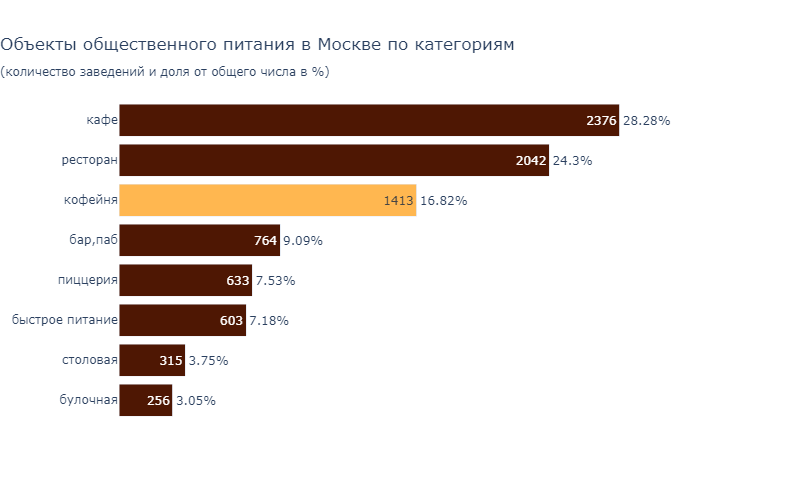

В датасете 8 категорий заведений, больше всего кафе (2377 заведения, это 28,3%), кофейни (1413 / 16,8%) — на третьем месте после ресторанов. Самые малочисленные категории — столовая и булочная — менее 4% каждая.

In [ ]:
g_count_category(False,
                 data.groupby('category')['seats'].agg(['median'])\
                     .sort_values(by='median'),
                 'Среднее количество (медиана) посадочных мест <br>'+\
                 'в заведениях общественного питания Москвы по категориям',
                 'Медиана', data['seats'].median())

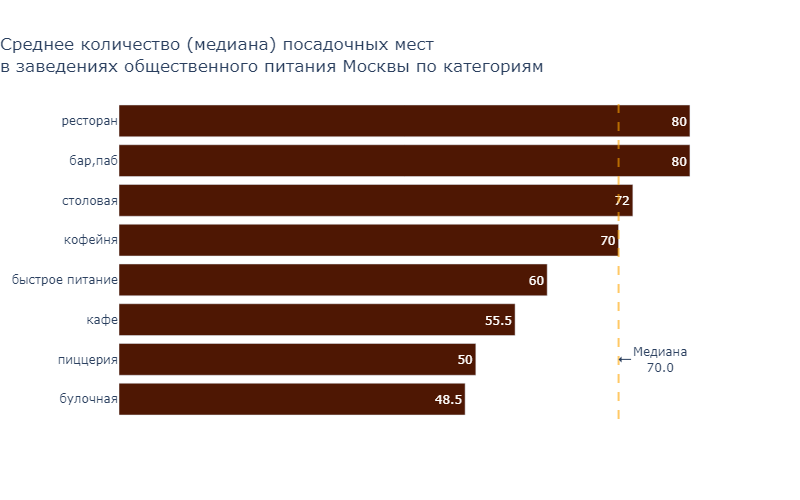

Среднее количество (медиана) посадочных мест в заведениях общепита в Москве — 70. Среди категорий наибольшее количество посадочных мест в ресторанах и барах/пабах — 80; в кофейнях — 70 (замыкают ТОП-4); минимум — в булочных (48-49).

------------------------------
Построим графики для соотношения сетевых и несетевых заведений (будет использован для презентации).

In [ ]:
# Данные для барплота: соотношение сетевых и несетевых по категориям в %
df_chain = data.pivot_table(index='category',
                            columns='chain',
                            values='name',
                            aggfunc='count')

df_chain['Сетевые'] = round((df_chain[True] /
                             (df_chain[False] + df_chain[True]))*100, 2)
df_chain['Несетевые'] = 100 - df_chain['Сетевые']
# сортировка по %% сетевых
df_chain = df_chain[['Сетевые', 'Несетевые']].sort_values(by='Сетевые',
                                                          ascending=True)

# Фигура и сетка
fig = go.Figure()

fig = make_subplots(2, 2, # сетка
                    # определяем типы данных для subplots
                    specs=[[{'type':'domain'}, {'type':'domain'}],
                           [{'type':'Pie'}, {'type':'xy'}]],
                    column_titles=['Всего', 'По категориям'], # некорр. работает
                    row_heights =[0.10, 0.9],
                    vertical_spacing = 0.02,
                    horizontal_spacing = 0.1)
# цвета
colors = {'Сетевые': colors2[0], 'Несетевые': colors2[1]}


# Т.к. subplot_titles некорректно работает вместе с annotations,
# а аннотации перекрывают друг друга и также сложно все расположить, —
# добавим заголовки текстом, используя формат Table.
# Не лучшее решение, но оно работает

fig.add_trace(go.Table(header = dict(values = ['Всего'],
                                     height = 50, align = ['center'],
                                     font = dict(size=20),
                                     fill = dict(color='rgba(0,0,0,0)')
                                     )),
              row=1, col=1)

fig.add_trace(go.Table(header = dict(values = ['По категориям'],
                                     height = 50, align = ['center'],
                                     font = dict(size=20),
                                     fill = dict(color='rgba(0,0,0,0)')
                                     )),
              row=1, col=2)

# bar по категориям
# trace отдельно — по сетевым, чтобы можно было отдельно задать формат подписей
fig.add_trace(go.Bar(y = df_chain.index,
                     x = df_chain['Сетевые'],
                     name='',
                     text=df_chain['Сетевые'],
                     marker_color=colors['Сетевые'],
                     textposition='inside',
                     texttemplate='%{x}%',
                     orientation='h',
                     showlegend = False  # убираем легенду, оставим от pie
                     ),
              row=2, col=2)

# trace по несетевым, без подписей
fig.add_trace(go.Bar(y = df_chain.index,
                     x = df_chain['Несетевые'],
                     name='',
                     marker_color=colors['Несетевые'],
                     orientation='h',
                     showlegend=False  # убираем легенду, оставим от pie
                     ),
              row=2, col=2)

fig.update_layout(barmode='stack', # группируем оба барплота в накопительный
                  plot_bgcolor='rgba(0,0,0,0)',
                  paper_bgcolor='rgba(0,0,0,0)' # прозрачный фон
                  )

# убираем лишние элементы
fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False)
fig.update_yaxes(showgrid=False, zeroline=False)

# Pie
# Данные
value_notalert = data.groupby('chain')['name'].count()[False]
value_alert = data.groupby('chain')['name'].count()[True]

# строим pie
fig.add_trace(go.Pie(values=[value_notalert,
                             value_alert],
                    labels=['Несетевые', 'Сетевые'],
                    hole=0.75,
                    # в подписях оставим сетевые / несетевые, без значений
                    textinfo='label',
                    textposition='outside',
                    marker=dict(colors=[colors['Несетевые'], colors['Сетевые']],
                                line=dict(color='#FFFFFF', width=7)),
                    # повернем график, чтобы наичнался с сетевых;
                    #сетевые занимают 38,1%, угол поворота: 132.84 = 360*0,381
                    rotation=value_alert/(value_alert+value_notalert)*360,
                    ),
              row=2, col=1)

# заголовок по центу pie (аннотацией), из 2х частей: % (больше шрифт) и подпись
title1 = '{:.1%}'.format(value_alert/(value_alert+value_notalert))
title2 = 'общая доля<br>сетевых заведений'

fig.update_layout(
  annotations=[dict(text=title1, x=0.23, y=0.47, font_size=38, showarrow=False),
               dict(text=title2, x=0.23, y=0.32, font_size=18, showarrow=False)]
  )


# настройки для легенды
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.85,
    xanchor="right",
    x=0.97,
    bgcolor="#FFF",
))

# общий заголовок
fig.update_layout(height=500,
                  width=1200,
                  title_text='Соотношение сетевых и несетевых заведений',
                  title_x=0.5,
                  title_font_size=24)

fig.show()

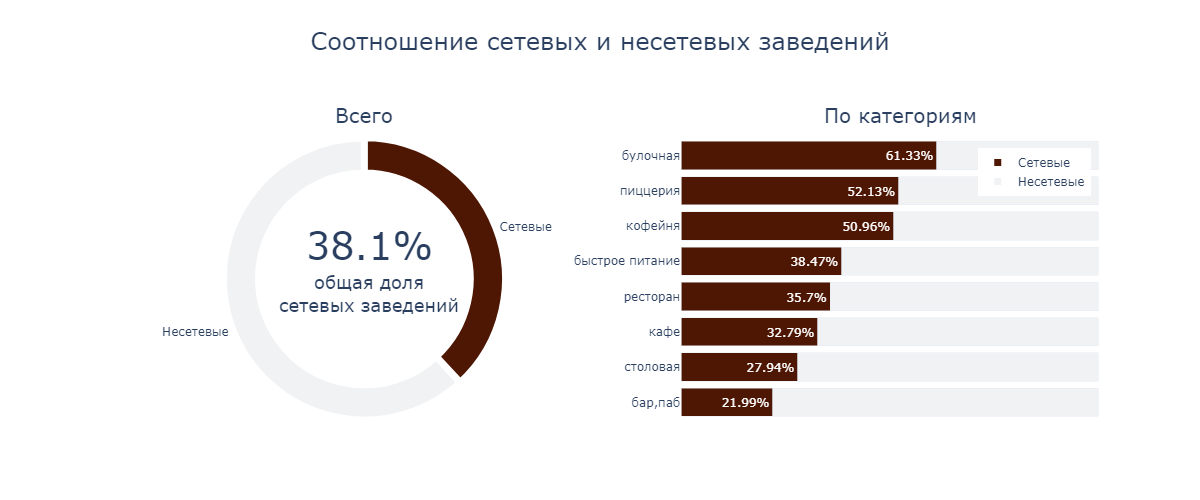

В общем количестве заведений — больше несетевых, доля сетевых составляет чуть более 38%. В разрезе категорий: булочные чаще сетевые (61,3%), пиццерий и кофеен почти равное соотношение сетевых и несетевых с небольшим перевесом первых (52,2% сетевых пиццерий, 51% сетевых коффеен),  в остальных категориях доля несетевых выше.

### Топ-15 популярных сетей

Сгруппируем данные по названиям заведений и найдем топ-15 популярных сетей — по количеству заведений сети в регионе.

In [ ]:
data[data['chain']].groupby('name').agg(total_count=('name', 'count'))\
                   .nlargest(15, 'total_count')\
                   .style\
                         .set_caption('ТОП-15 сетевых заведений')\
                         .set_table_styles([{'selector': 'caption',
                                             'props': [('font-size', '18px')]}])

In [ ]:
# построим линейчатую диагарамму
g_count_category(False,
                 data[data['chain']].groupby('name')\
                                    .agg(total_count=('name', 'count'))\
                                    .nlargest(15, 'total_count')\
                                    .sort_values(by='total_count'),
                 'ТОП-15 сетевых заведений по количеству точек в Москве',
                 'Медиана',
                 data[data['chain']].groupby('name')\
                                    .agg(total_count=('name', 'count'))\
                                    .nlargest(15, 'total_count')['total_count']\
                                    .median(),
                 i_height=42*15)

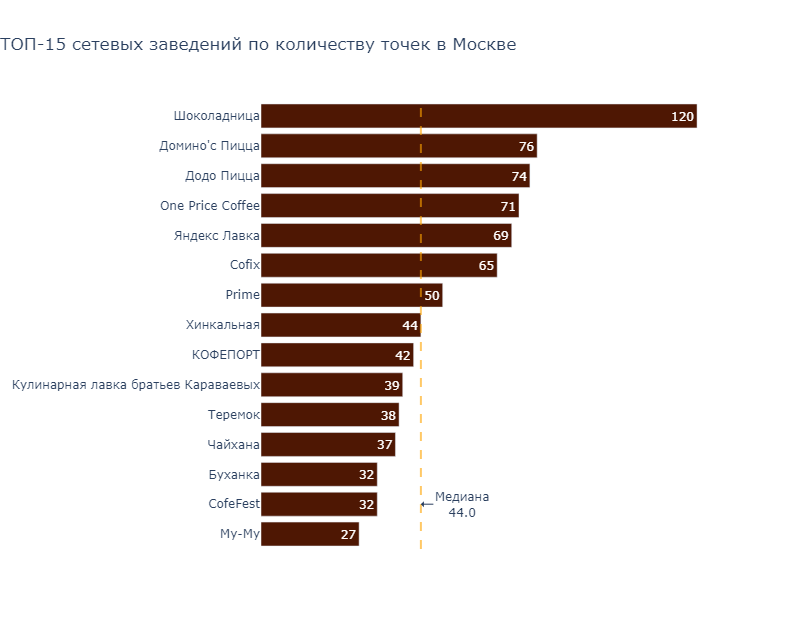

Лидер ТОПа сетевых заведений по количеству точек в Москве — Шоколадница: 120 заведений.

Для ТОП-15 характерен большой разброс количества точек сетей: выделяется на первом месте Шоколадница — 120 точек, в 2,7 раза больше чем медиана по ТОП-15. Далее идут — пять сетей: Домино'с Пицца, Додо Пицца, One Price Coffee, Яндекс Лавка, Cofix — с количеством точек от 65 до 76. У остальных сетей из ТОПа количество точек не превышает 50, замыкает ТОП-15 "Му-му" (27 точек).

Посмотрим характеристики заведений из ТОПа-15.


In [ ]:
# список ТОП-15
top_chain = data[data['chain']].groupby('name')\
                               .agg(total_count=('name', 'count'))\
                               .nlargest(15, 'total_count').index

In [ ]:
# основные показатели:кол-во мест, средний чек, средний рейтинг
df_chain_top = data.query('name in @top_chain & chain').groupby('name')\
                    .agg(total_count=('name', 'count'),
                          median_seats=('seats', 'median'),
                          median_bill=('middle_avg_bill', 'median'),
                          median_coffee_cup=('middle_coffee_cup', 'median'),
                          mean_rating=('rating', 'mean')
                        ).sort_values(by='total_count', ascending=False)

df_chain_top.loc['Весь ТОП-15'] = [df_chain_top.iloc[0:14, 0].sum(),
                               df_chain_top.iloc[0:14, 1].median(),
                               df_chain_top.iloc[0:14, 2].median(),
                               df_chain_top.iloc[0:14, 3].median(),
                               df_chain_top.iloc[0:14, 4].mean()]

df_chain_top.loc['Все сетевые'] = [data.query('chain').shape[0],
                            data.query('chain')['seats'].median(),
                            data.query('chain')['middle_avg_bill'].median(),
                            data.query('chain')['middle_coffee_cup'].median(),
                            data.query('chain')['rating'].mean()]

df_chain_top.loc['Все заведения общепита в Москве'] = [data.shape[0],
                                            data['seats'].median(),
                                            data['middle_avg_bill'].median(),
                                            data['middle_coffee_cup'].median(),
                                            data['rating'].mean()]

df_chain_top.style.format('{:.1f}', na_rep='-')\
  .set_caption('ТОП-15 сетевых заведений: основные показатели')\
  .set_table_styles([{'selector': 'caption', 'props': [('font-size', '18px')]}])

Средние значения по ТОП-15 по показателям: количество посадочных мест, оценка среднего чека, оценка стоимости чашки капучино и рейтинг — немного ниже средних значений по сравнению со всеми сетевыми и со всеми заведениями общепита.

Другие закономерности в ТОПе не выделяются, в основном есть разброс значений показателей; средний рейтинг у большинства 4 и выше.

In [ ]:
# ТОП-15 сетевых заведений по категориям
data.query('name in @top_chain').pivot_table(index='name',
                                             columns='category',
                                             values='rating',
                                             aggfunc='count',
                                             margins=True)\
    .sort_values(by='All', ascending=False)\
    .T.sort_values(by='All', ascending=False).T\
    .style.format('{:.0f}', na_rep='')\
          .set_caption('ТОП-15 сетевых заведений по категориям')\
          .set_table_styles([{'selector': 'caption',
                              'props': [('font-size', '16px')]}])

Большинство заведений из ТОП-15 (91%) относятся к категориям: кофейни, рестораны, пиццерии, кафе. Треть из 15 крупнейших сетей — кофейни.

In [ ]:
data.query('name in @top_chain').pivot_table(index='name',
                                             columns='dist',
                                             values='rating',
                                             aggfunc='count',
                                             margins=True)\
    .sort_values(by='All', ascending=False).T\
    .sort_values(by='All', ascending=False).T\
    .style.format('{:.0f}', na_rep='-')\
          .set_caption('ТОП-15 сетевых заведений по округам')\
          .set_table_styles([{'selector': 'caption',
                              'props': [('font-size', '16px')]}])\
          .background_gradient(cmap='RdPu',
                                axis=1,
                                subset=['ЦАО',	'ЮАО',	'ЗАО',
                                        'САО',	'СВАО',	'ВАО',
                                        'ЮЗАО',	'ЮВАО',	'СЗАО'])\
          .applymap(lambda x: '' if x>0 else 'background: lightgray')

Сетевые заведения из ТОПа чаще расположены в ЦАО. Можно отметить исключения:
- Домино'с Пицца, Додо Пицца, Яндекс Лавка — больше точек расположены не в ЦАО, что видимо, объясняется большой долей продаж с доставкой;
- Теремок, Чайхана, Буханка — также приоритетное расположение не в ЦАО, скорее всего, из-за ориентира на более экономичный класс заведений.

### Расположение заведений по округам

In [ ]:
g_count_category(True,
                 data.groupby('district')['name'].agg(['count'])
                    .sort_values(by='count'),
                 'Объекты общественного питания в Москве по округам<br>'+\
                 '<sub>(количество заведений и доля от общего числа в %)')

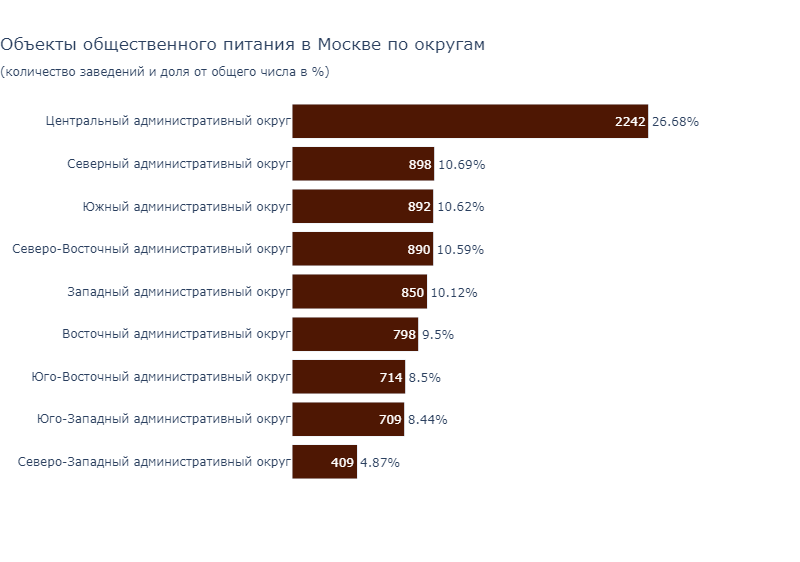

В датасете представлены данные по девяти округам Москвы (нет данных по Зеленоградскому, Троицкому, Новомосковскому).

Количество заведений в ЦАО значительно превышает показатели других округов: здесь расположено 2239 точек или 26,7% от общего числа. Минимум заведений общепита — в СЗАО: 409 точек, менее 5%.

Посмотрим, как выглядит на карте

In [ ]:
# загружаем JSON-файл с границами округов Москвы
state_geo = 'https://code.s3.yandex.net/data-analyst/admin_level_geomap.geojson'

#координаты центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

In [ ]:
# создаем карту Москвы
map_district = Map(location=[moscow_lat, moscow_lng],
                   zoom_start=10,
                   tiles = "cartodbpositron")

# создаем хороплет с помощью конструктора Choropleth и добавляем его на карту
cp = folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=data.groupby('district', as_index=False).agg(count=('name', 'count')),
    columns=['district', 'count'],
    key_on='feature.name',
    fill_color='OrRd',
    fill_opacity=1,
    line_opacity=0.3,
    legend_name='Количество заведений общепита'
).add_to(map_district)

# выводим карту
display(map_district)

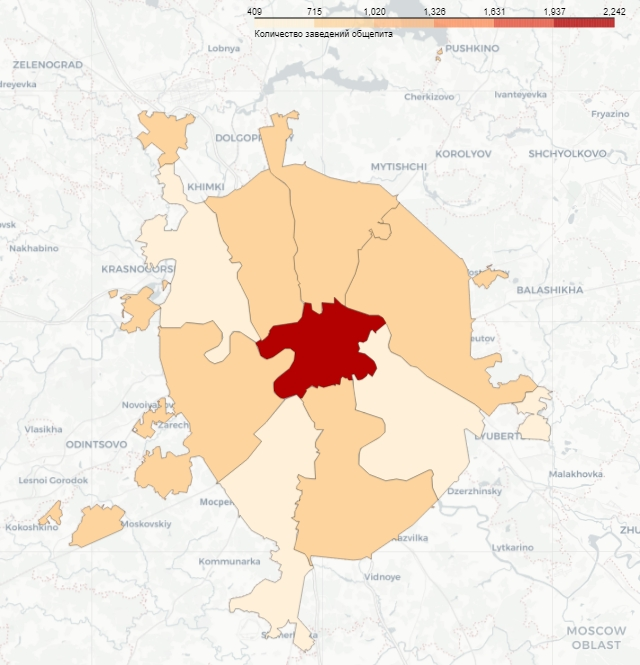

In [ ]:
df_district_category = data.pivot_table(index='district',
                                        columns='category',
                                        values='rating',
                                        aggfunc='count',
                                        margins=True)\
                          .sort_values(by='All', ascending=False).T\
                          .sort_values(by='All', ascending=False).T

df_district_category.style.format('{:.0f}', na_rep='-')\
            .set_caption('Количество заведений по округам Москвы и категориям')\
            .set_table_styles([{'selector': 'caption',
                                'props': [('font-size', '16px')]}])


Построим накопительную диаграмму для визуализации колличества заведений по округам и категориям

In [ ]:
# Объявим функцию для анализа в разрезе параметра (округа, улицы) и категорий

def category_absolute (data, parameter, title, i_height=500):
  '''
  Функция принимает датасет и анализируемый параметр
  Вовращает сводную таблицу,
  строит график в разрезе параметра по категориям заведений
  '''

  #Данные
  df_category = data.pivot_table(index=parameter,
                                 columns='category',
                                 values='rating',
                                 aggfunc='count',
                                 margins=True)\
                            .sort_values(by='All', ascending=False).T\
                            .sort_values(by='All', ascending=False).T
  row=df_category.shape[0]-1
  col=df_category.shape[1]

  #параметр и категории
  df_bar = df_category.sort_values(by='All').iloc[0:row, 1:col]
  #общее кол-во заведений по параметру
  customdata_bar = df_category.sort_values(by='All').iloc[0:row, 0]

  #накопительная диаграмма по параметру и категориям
  fig=px.bar(
            df_bar,
            y=df_bar.index,
            x=df_bar.columns,
            barmode="stack",
            text_auto=True,
            height=i_height,
            #width=1000,
            labels={parameter:'', 'value':''}, #уберем подписи осей
            title=title
            )

  fig.update_traces(textangle=0, textposition="inside")

  #общее кол-во заведений по окургам
  fig.add_trace(go.Bar(y = df_bar.index,
                       x = [0]*df_bar.shape[0],
                       name='',
                       showlegend=False,
                       customdata = customdata_bar,
                       texttemplate="Всего <br>%{customdata}",
                       textposition='outside',
                       orientation='h'))

  fig.update_layout(barmode='stack',
                    title={'x':0},
                    legend=dict(title='Категории'),
                    uniformtext_minsize=10,
                    uniformtext_mode='hide')

  fig.update_xaxes(showticklabels=False, showgrid=False, automargin=True,
                   zeroline=False)
  fig.update_yaxes(showgrid=False, zeroline=False, automargin=True)

  fig.show()

  return df_category.style.format('{:.0f}', na_rep='-')\
                      .set_caption(title)\
                      .set_table_styles([{'selector': 'caption',
                                          'props': [('font-size', '16px')]}])

In [ ]:
district_pivot = category_absolute(data, 'dist',
                         'Количество заведений по округам Москвы и категориям')

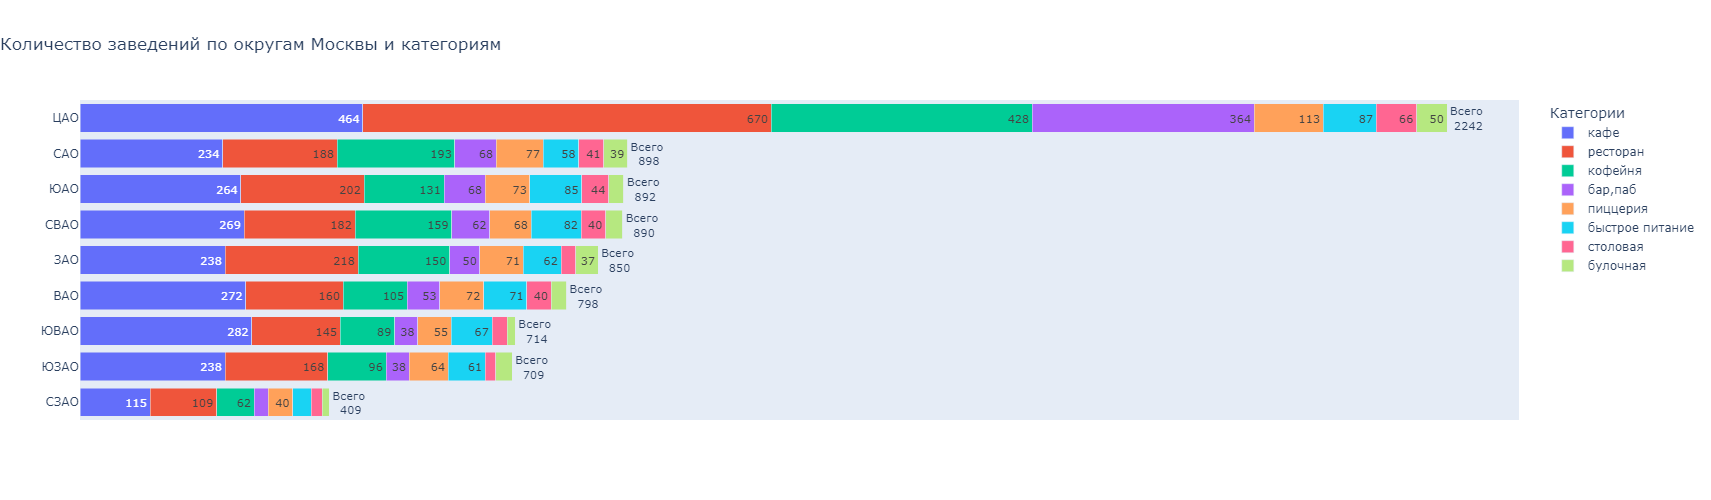

Количество заведений в ЦАО значительно первышает остальные округа, посмотрим распределение по категориям в %%

In [ ]:
# Функция для анализа в разрезе параметра (округа, улицы) и категорий, в %%

def category_percent (data, parameter, title, i_height=500):
  '''
  Функция принимает датасет и анализируемый параметр
  строит график в разрезе параметра по категориям заведений, в %%
  '''
  #Данные

  df_category = data.pivot_table(index=parameter,
                                 columns='category',
                                 values='rating',
                                 aggfunc='count',
                                 margins=True)\
                    .sort_values(by='All', ascending=False).T\
                    .sort_values(by='All', ascending=False).T
  row=df_category.shape[0]-1
  col=df_category.shape[1]

  #параметр и категории
  df_bar = df_category.sort_values(by='All').iloc[0:row, 1:col]
  #общее кол-во заведений по параметру
  customdata_bar = df_category.sort_values(by='All').iloc[0:row, 0]

  #нормализованная диаграмма по параметрy и категориям

  df_bar_p = df_bar.apply(lambda x: x/x.sum(), axis=1) #параметр и категории %%

  fig=px.bar(
            df_bar_p,
            y=df_bar_p.index,
            x=df_bar_p.columns,
            barmode="stack",
            text_auto=True,
            height=i_height,
            #width=1000,
            labels={parameter:'', 'value':''}, #уберем подписи осей
            title=title
            )

  fig.update_traces(textangle=0,
                    textposition="inside",
                    texttemplate = '%{value:0.1%}')
  fig.update_layout(uniformtext_minsize=10,
                    uniformtext_mode='hide',
                    title={'x':0},
                    legend=dict(title='Категории'))

  fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False)
  fig.update_yaxes(showgrid=False, zeroline=False, automargin=True)

  fig.show()

In [ ]:
category_percent(data, 'dist',
              'Заведения общепита по округам Москвы и категориям <br>'+\
              '(доля категории в % от общего числа заведений в каждом округе)')

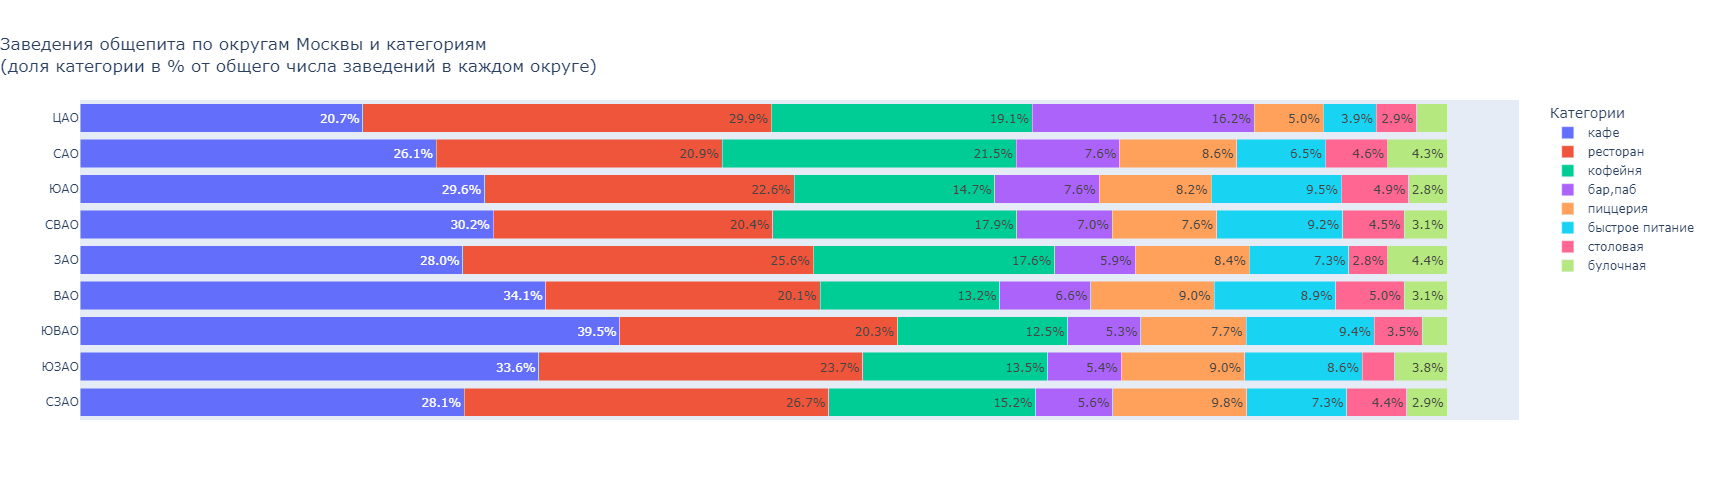

Распределение по округам немного различается. Например, в ЮВАО - доля кафе выше, чем в других округах; в ЦАО — выделяется доля баров/пабов

Рассмотрим данные раздельно

In [ ]:
# строим фасетные графики по долям
#  в разрезе округов
df_group = data.groupby(['dist', 'category'])['rating'].agg(['count'])\
                                                       .reset_index()
df_group['group_percent'] = (df_group['count'] /
                             df_group.groupby('dist')['count']
                             .transform('sum')*100)
fig = px.bar(
    df_group,
    x='category',
    y='group_percent',
    facet_col='dist',
    height = 420,
    labels={'category':'', 'group_percent':'Доли категорий, %', 'dist':'округ'},
    title='Распределение заведений в каждом округе по категориям (доли %%)'
)
fig.show()

# в разрезе категорий
df_group['group_percent_dist'] = (df_group['count'] /
                                  df_group.groupby('category')['count']
                                  .transform('sum')*100)

fig = px.bar(
    df_group,
    x='dist',
    y='group_percent_dist',
    facet_col='category',
    height = 420,
    labels={'category':'категория<br>',
            'group_percent_dist':'Доли округов, %',
            'dist':'округ'},
    title='Распределение заведений каждой категории по округам (доли %%)'
)

fig.show()



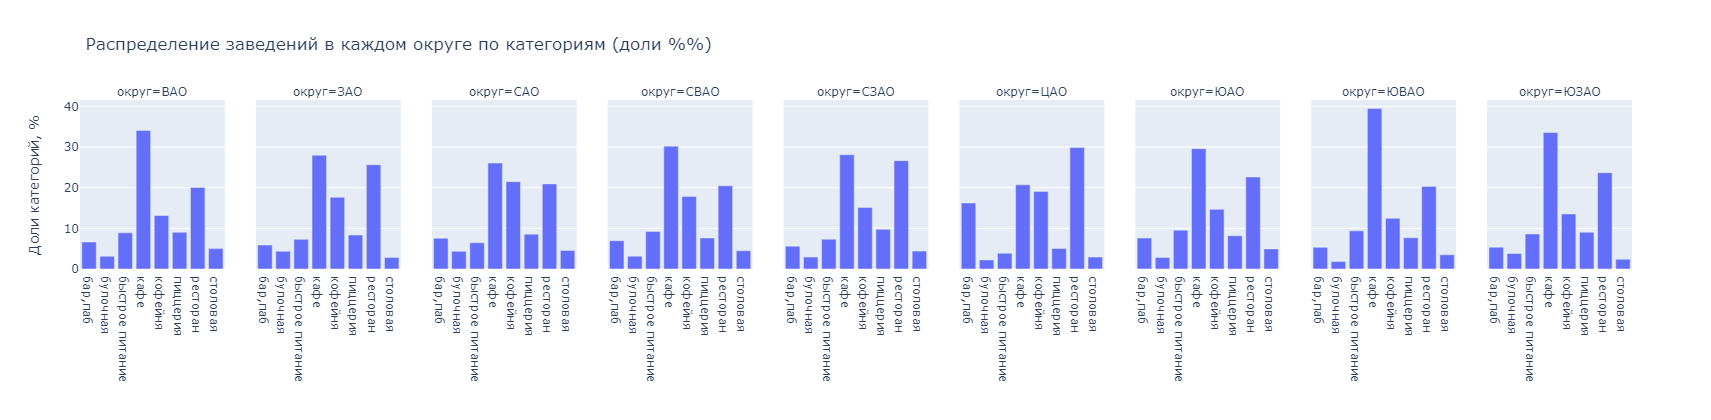

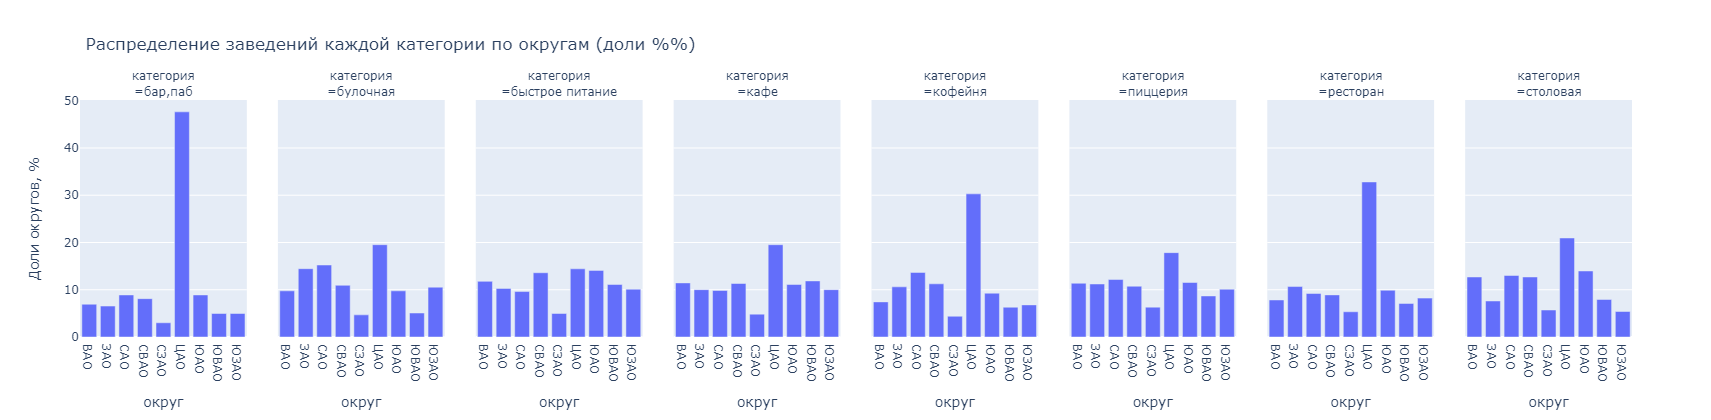

Топовые категории заведений по округам (составляющие 20% и более всех точек в округе):
 - ЦАО — рестораны, кафе;
 - САО — кафе, кофейни, рестораны;
 - Остальные округа — кафе, рестораны.


Больше всего кофеен — в ЦАО: здесь находится почти каждая третья кофейня  (30,2%), также ЦАО выделяется и в других популярных категориях заведений: рестораны (32,8% всех ресторанов в ЦАО), бары / пабы (почти половина - 47,6% всех баров Мск находятся в ЦАО); при этом доля баров/пабов в самом ЦАО — 16,2% — значительно превышает этот показатель по другим округам.


In [ ]:
# добавим отдельный график по ЦАО (для презентации)

df_cao = data.query('dist == "ЦАО"').groupby('category')['name'].count()\
                                    .sort_values()

fig = go.Figure()

fig.add_trace(go.Bar(y = df_cao.index,
                     x= df_cao.values,
                    name='',
                    text=df_cao.values,
                    orientation='h',
                    marker=dict(color='#FFFFFF',
                                 line=dict(color=colors2[0], width=1)),
                    textposition='outside'
                    ))

fig.update_layout(title={'x':0,
                         'text':'Заведения общепита в ЦАО по категориям'},
                  width = 500, height = 400,
                  plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')

fig.update_yaxes(showgrid=False, zeroline=False, automargin=True)
fig.update_xaxes(showgrid=False, zeroline=False, automargin=True,
                 range = [0,800], showticklabels=False)
fig.show()

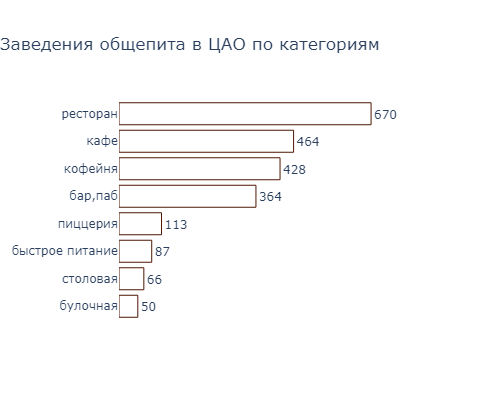

### Рейтинги заведений

Посмотрим медианное значение рейтинга заведений по категориям

In [ ]:
# Построим график, сразу сделаем функцию
def rating_chart(data, parameter, title):
  '''
  Функция принимает датасет или его срез (data)
  и строит барчат в разрезе параметра (parameter)
  '''

  # данные
  df_bar_rating = data.groupby(parameter).agg(rating=('rating', 'mean'))\
                                         .sort_values(by='rating')

  df_bar_rating['to_max'] = 5 -  df_bar_rating['rating']

  # диаграмма
  fig = go.Figure()

  fig.add_trace(go.Bar(y = df_bar_rating.index,
                      x = df_bar_rating['rating'],
                      name='',
                      text=df_bar_rating['rating'],
                      marker_color=colors2[0],
                      textposition='inside', orientation='h'))
  fig.update_traces(texttemplate='%{text:.2f}')

  fig.add_trace(go.Bar(y = df_bar_rating.index,
                      x = df_bar_rating['to_max'],
                      name='',
                      marker_color=colors2[1],
                      orientation='h'))

  fig.update_layout(height=400, width=500,
                    barmode='stack',
                    plot_bgcolor='rgba(0,0,0,0)',
                    paper_bgcolor='rgba(0,0,0,0)',
                    showlegend=False,
                    title=title,
                    xaxis_title='Среднее значение рейтинга, '+\
                                'по пятибалльной шкале'
                    )

  fig.update_layout(title={'x':0})

  fig.update_yaxes(showgrid=False, zeroline=False, automargin=True)


  fig.update_xaxes(tickvals=[0, 5],
                   ticktext=['0', '5'],
                   zeroline=False)

  fig.show()

In [ ]:
rating_chart(data,
             'category',
             "Средний рейтинг заведений общепита Москвы<br>по категориям")

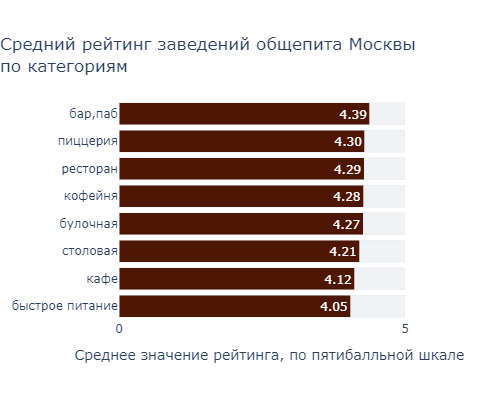

Рейтинги отличаются незначительно, сгруппируем категории

In [ ]:
# рейтинги по категориям
df_rating = data.groupby('category').agg(rating=('rating', 'mean'))
df_rating['rating'] = round(df_rating['rating'], 1)

# сгруппируем категории по рейтингам
df_group_ration = pd.DataFrame(columns=['category', 'rating'])
i = 0
for r in df_rating['rating'].unique():
  df_group_ration.loc[i, 'category'] = \
     '<br>'.join(df_rating[df_rating['rating'] == r].index.to_list())
  df_group_ration.loc[i, 'rating'] = r
  i += 1


In [ ]:
df_group_ration['category'] = df_group_ration['category'].str\
                                            .replace('быстрое питание',
                                                     'быстрое<br>питание',
                                                     regex=True)
df_group_ration = df_group_ration.sort_values(by = 'rating', ascending=False)

In [ ]:
# построим барчат
labels = df_group_ration['category']
values = df_group_ration['rating']

fig = go.Figure()

# диаграмма
fig.add_trace(go.Bar(x = labels,
                     y = values,
                     name='',
                     text=labels,
                     textposition='inside',
                     insidetextanchor="middle",
                     marker=dict(color='#FFFFFF',
                                 line=dict(color=colors2[0], width=2))
                    ))

#добавим доп.подписи

fig.add_trace(go.Bar(x = labels, y = [0]*df_group_ration.shape[0], name='',
                    customdata = values,
                    texttemplate="%{customdata}",
                    textposition='outside', textfont=dict(size=20)
                    ))

fig.update_layout(barmode='stack', title={'x': 0.5,
                                          'text':'Рейтинги заведений общепита'+\
                                                 '<br>по категориям'},
                  title_font_size=20,
                  height=400, width=600,
                  showlegend=False,
                  #plot_bgcolor='rgba(0,0,0,0)',
                  paper_bgcolor='rgba(0,0,0,0)'
)
fig.update_yaxes(range=[0, 5],
                 showticklabels=False)

fig.update_xaxes(showticklabels=False,
                 linecolor='black',
                 showline=True,
                 linewidth=1)

fig.show()

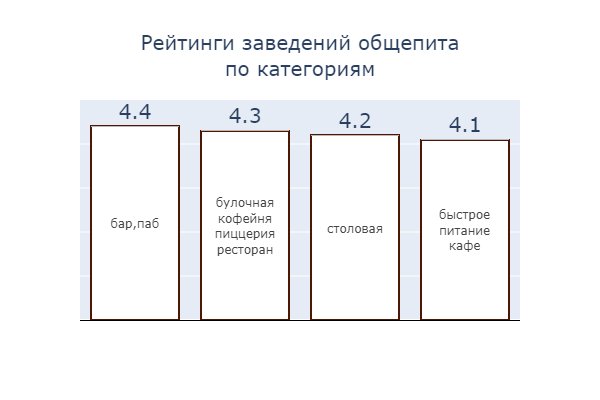

Средний рейтинг разных категорий заведений отличается на +/- 0,2 пункта (из 5). Посмотрим распределение рейтингов.


In [ ]:
fig = px.box(data, x="category", y="rating",
             labels={'rating':'Рейтинг', 'category':''},
             title='Распределение рейтингов в разрезе категорий заведений')
fig.update_xaxes(categoryorder='array',
                 categoryarray= data.groupby('category')['rating'].median()\
                                    .sort_values().index.to_list())
fig.update_layout(title={'x':0})
fig.show()

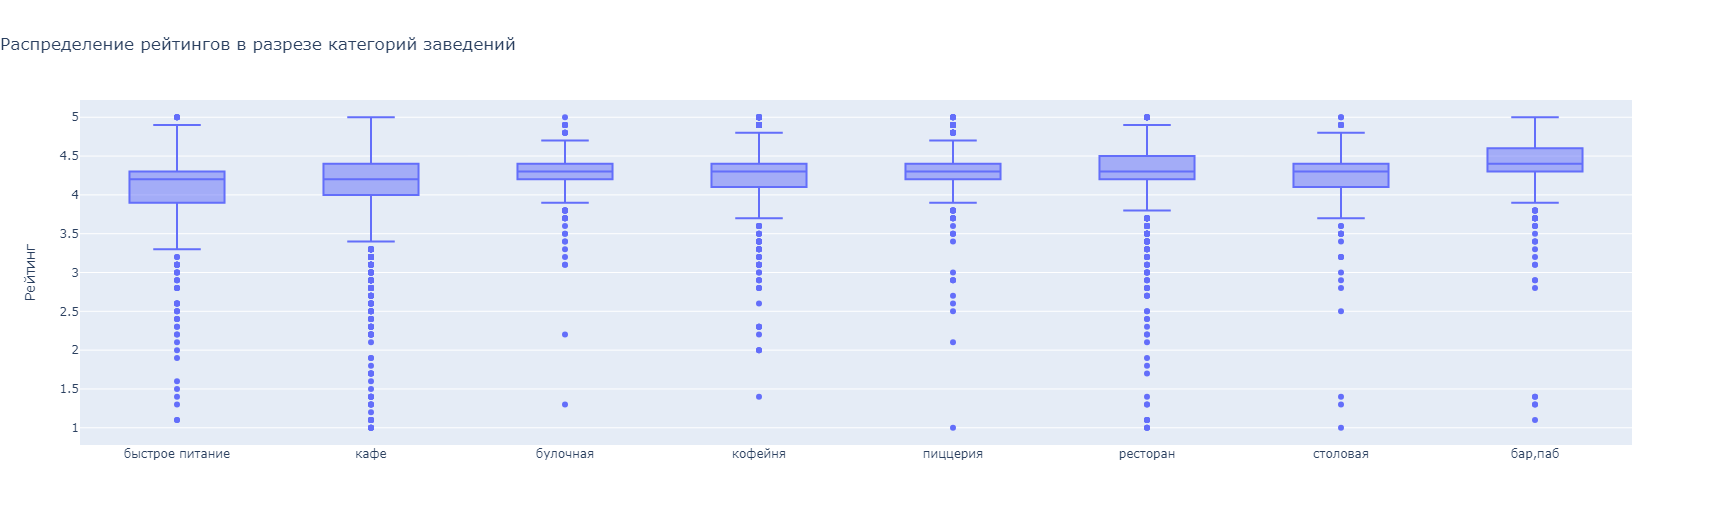

Можно выделить бары/пабы — кроме самой высокого медианного рейтинга среди категорий, максимальные оценки доходят до 5.0, 75% оценок выше 4.3, 25% оценок выше 4.6.

Самые низкие оценки у заведений быстрого питания — одна из самых низких медиан среди категория (4.2), минимальные оценки (без учета выбросов) доходят до 3.3 и самый низкий уровень q1 (нижний квартиль), т.е. нижняя граница 75% оценок 3.9 (для сравнения у пиццерий этот показатель находится на 4.2).


--------
Посмотрим распределение рейтингов по округам.

In [ ]:
rating_df = data.groupby('district', as_index=False)['rating'].agg('mean')\
                .sort_values(by='rating', ascending=False)
rating_df.rename(columns={'district': 'Округ', 'rating': 'Рейтинг'})\
      .style.format(precision=2)\
      .set_caption('Средний рейтинг заведений общепита Москвы <br>по округам')\
      .set_table_styles([{'selector': 'caption',
                          'props': [('font-size', '16px')]}])

В лидерах опять ЦАО со средним рейтингом 4.4, в большинстве округов средний рейтинг 4.2, минимальный — 4.1 — в ЮВАО.

Визуализируем данные на карте

In [ ]:
# загружаем JSON-файл с границами округов Москвы
state_geo = 'https://code.s3.yandex.net/data-analyst/admin_level_geomap.geojson'

#координаты центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

In [ ]:
#Создадим функцию для отрисовки карты

def map_district_msk (data_map, parameter, title_legend):
  # функция принимает датасет, parameter - параметр, по которому строим карту (напр., 'rating')
  # title_legend - заголовок легенды, hover=True - надо ли отображать всплывающие подсказки

  # создаем карту Москвы
  map_district = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles = "cartodbpositron")

  # создаем хороплет с помощью конструктора Choropleth и добавляем его на карту
  cp = folium.Choropleth(
      geo_data=state_geo,
      name="choropleth",
      data=data_map,
      columns=['district', parameter],
      key_on='feature.name',
      fill_color='OrRd',
      fill_opacity=1,
      line_opacity=0.3,
      legend_name=title_legend
  ).add_to(map_district)

  # добавим районы и рейтинги во всплавыющие подсказки
  state_data_indexed = data_map.set_index('district')

  for s in cp.geojson.data['features']:
    s['properties'][parameter] = state_data_indexed.loc[s['name'], parameter]

  folium.GeoJsonTooltip(['name', parameter]).add_to(cp.geojson)

  folium.LayerControl().add_to(map_district)


  # выводим карту
  display(map_district)

In [ ]:
map_district_msk(
    data_map = data.groupby('district', as_index=False)['rating'].agg('mean'),
    parameter = 'rating',
    title_legend = 'Средний рейтинг заведений по районам')

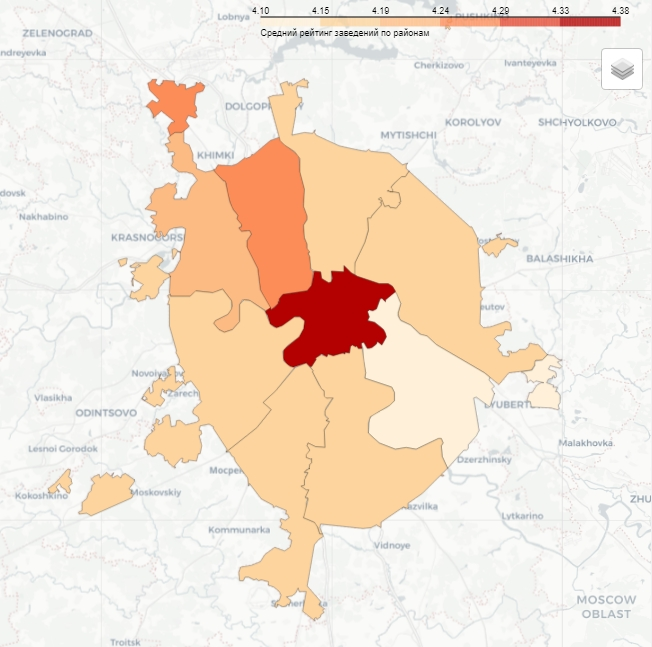

Отобразим все заведения датасета на карте с помощью кластеров.


In [ ]:
# создаём карту Москвы
map_all = Map(location=[moscow_lat, moscow_lng], zoom_start=10)
# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(map_all)

# пишем функцию, которая принимает строку датафрейма,
# создаёт маркер в текущей точке и добавляет его в кластер marker_cluster
def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['rating']}",
    ).add_to(marker_cluster)

# применяем функцию create_clusters() к каждой строке датафрейма
data.apply(create_clusters, axis=1)

# выводим карту
map_all

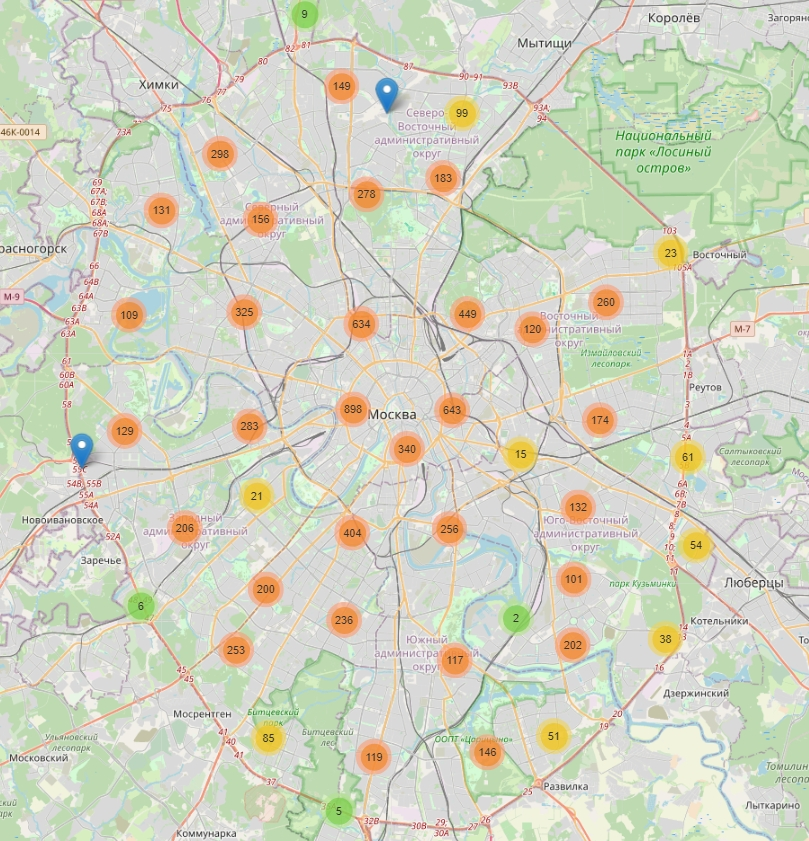

Еще раз убедились, что в центре больше заведений.

###ТОП-15 улиц

Сгруппируем данные по названиям улиц и найдем топ-15, где расположено самое большое количество заведений в Москве.

In [ ]:
# построим линейчатую диаграмму
g_count_category(False,
                 data.groupby('street').agg(total_count=('name', 'count'))\
                      .sort_values(by='total_count').tail(15),
                 'ТОП-15 улиц Москвы по количеству заведений общепита',
                 i_height=50*15)

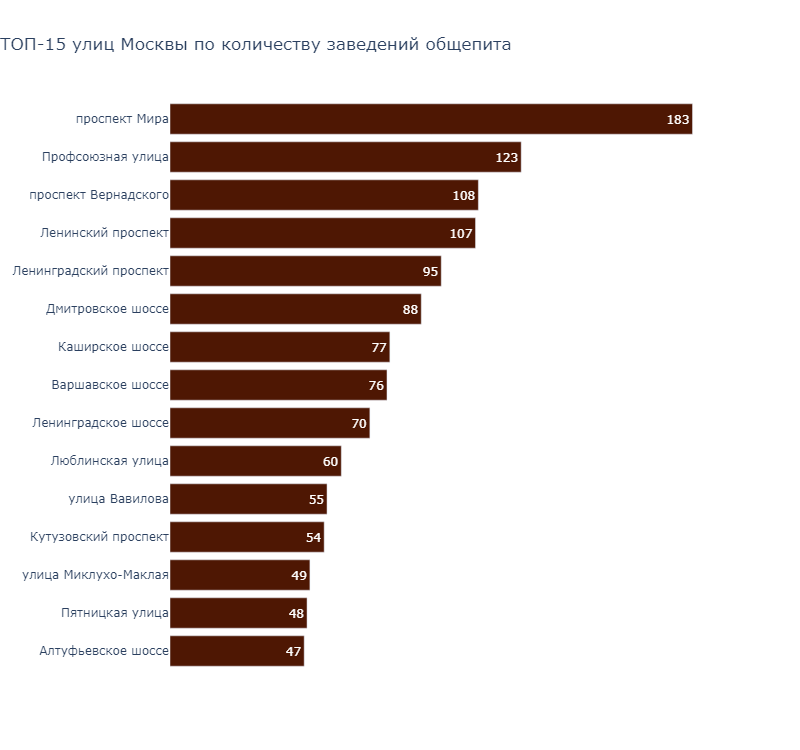

In [ ]:
# список ТОП-15
top_15_street = data.groupby('street').agg(total_count=('name', 'count'))\
                                      .nlargest(15, 'total_count').index

# функция для построения накопительного графика
title_chart='ТОП-15 улиц Москвы по количеству заведений общепита<br>'+\
            '(количество заведений на улице всего и по категориям)'
street_top15_pivot = category_absolute(data.query('street in @top_15_street'),
                                       'street',
                                       title_chart,
                                       i_height=800)

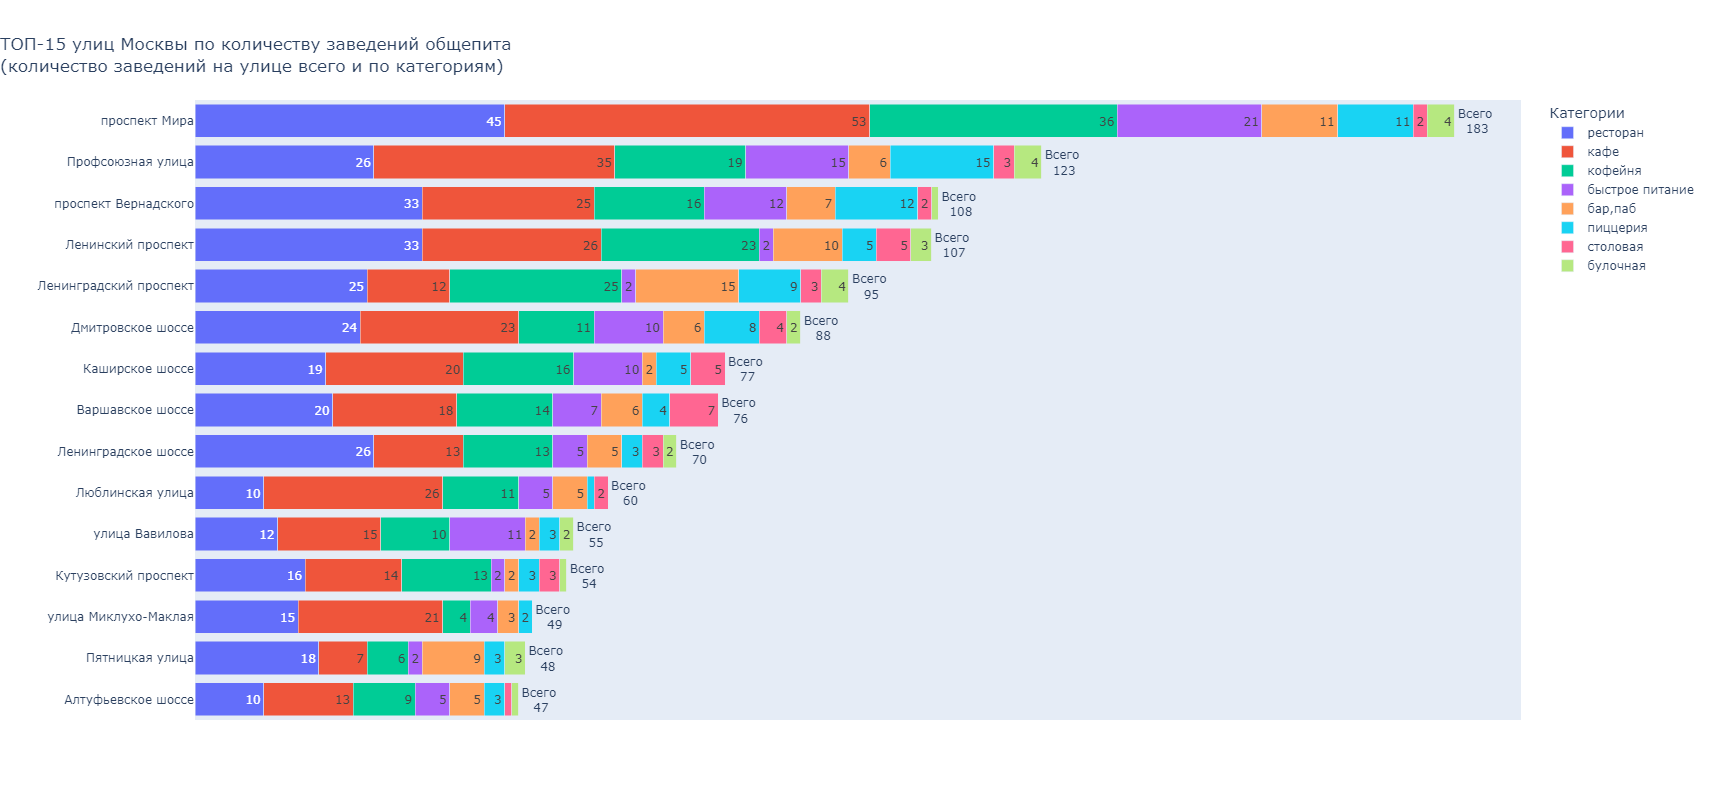

In [ ]:
# функция для построения нормализованного накопительного графика
title_chart = 'ТОП-15 улиц Москвы по количеству заведений общепита<br>'+\
              '(доля категории в % от общего числа заведений на каждой улице)'
category_percent(data.query('street in @top_15_street'), 'street',
                 title_chart,
                 i_height=800)

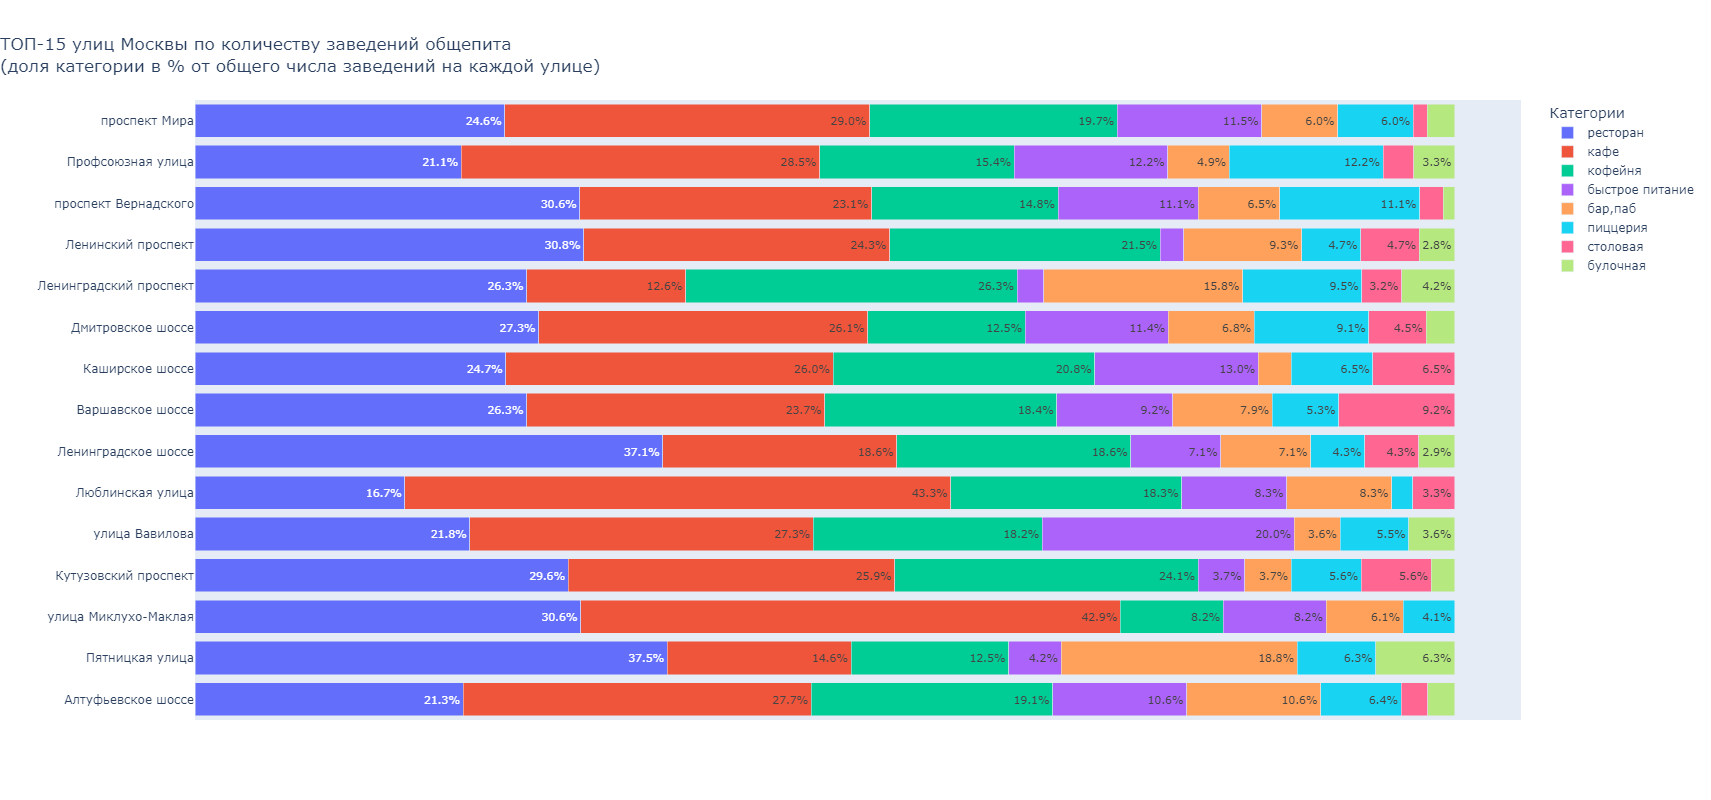

In [ ]:
# сколько заведений расположено на улицах из ТОП-15
data.query('street in @top_15_street')['name'].count()/data['name'].count()

0.1475839085931921

На ТОП-15 улиц расположено 1238 заведений общепита, или 14,7% - т.е. каждое седьое заведение находится на улице из ТОП-15. Самое большое количество точек на проспекте Мира - 183, замыкают ТОП Пятницкая улица  и Алтуфьевское шоссе - здесь по 47 заведений. В ТОП ожидаемо попали большие, оживленные улицы.


Посмотрим, сколько улиц, где, наоброт, расположена только одна точка общепита.

In [ ]:
#улицы, где расположено только одно заведение общепита
one = data.groupby('street')['name'].agg(['count']).query('count == 1').index

# посмотрим частые категорию и  округ
data.query('street in @one')[['district', 'category']].describe()


district category
count                                  484      484
unique                                   9        8
top     Центральный административный округ     кафе
freq                                   145      173

In [ ]:
# доля в общем кол-ве заведений
data.query('street in @one')['name'].count()/data['name'].count()

0.05760533206379433

In [ ]:
data.query('street in @one')['street'].sample(10)

2068           4-я улица 8 Марта
4892         Пестовский переулок
750             Северный бульвар
2736         11-я Парковая улица
1992            Анненский проезд
434     3-й Лихачёвский переулок
4718               улица Ильинка
3929        Сеченовский переулок
1332     1-й Балтийский переулок
3454         Скатертный переулок
Name: street, dtype: object

Улиц с одной точкой общепита — 485 (5,7% от всего числа заведений). Такие улицы присутствуют во всех девяти округах, больше всего в ЦАО. Как правило, это небольшие улицы и переулки, чаще всего на них расположены кафе.

### Режим работы работы заведений

Проанализируем, какое количество заведений работает ежедневно и круглосуточно. А также, какой самый популярный режим работы у заведений.

In [ ]:
# Функция для построение кольцевой диаграммы

def pie_chart(data_chart, alert_col, alert, maintitle, subtitle, label_alert):
# pie  по всем данным

  values_alert = data_chart[data_chart[alert_col]==alert]['name'].count()
  values_notalert = data_chart[~data_chart[alert_col]==alert]['name'].count()
  values_all=data_chart[alert_col].count()

  fig = go.Figure()

  fig.add_trace(go.Pie(values=[values_notalert,
                               values_alert],
                      labels=[' ', label_alert],
                      hole=0.75,
                      textinfo='label',
                      textposition='outside',
                      marker=dict(colors=[colors2[1], colors2[0]],
                                  line=dict(color='#FFFFFF', width=7)),
                      # повернем график, чтобы начинался с выделяемой категории
                      rotation=values_alert/values_all*360
                      ))

  # заголовок по центу pie (аннотацией) из двух частей %(больше шрифт) и подпись
  title1 = '{:.1%}'.format(values_alert/values_all)
  title2 = subtitle

  fig.update_layout(showlegend=False,
                    title_text=maintitle, title_x=0.5,
                    height=500, width=500,
                    annotations=[dict(text=title1,
                                      x=0.5, y=0.58,
                                      font_size=38,
                                      showarrow=False),
                                 dict(text=title2,
                                      x=0.5, y=0.4,
                                      font_size=18,
                                      showarrow=False)]
      )
  fig.show()

In [ ]:
pie_chart(data_chart=data[~data['hours'].isna()],
          alert_col = 'is_24/7',
          alert = True,
          maintitle="Доля заведений, работающих 24/7",
          subtitle = 'заведений работают<br>ежедневно <br>и круглосуточно',
          label_alert = '24/7')

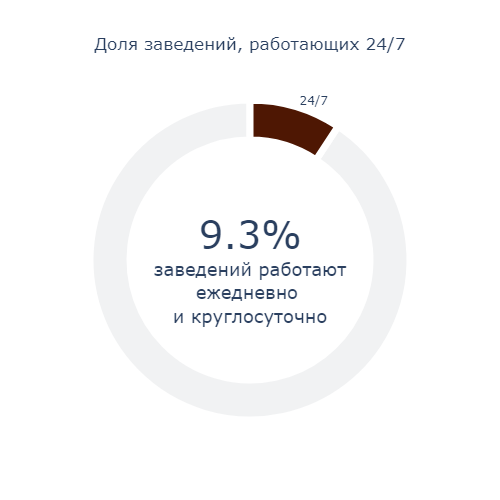

Проанализируем график работы по дням

In [ ]:
# добавим поле с графиком работы (закодируем рабочий/выходной)
def func_day (row):
  days = ''
  if pd.isnull(row['hours']): # исключаем незаполненные данные
    return np.nan
  for d in ['mo_start', 'tu_start', 'we_start', 'th_start',
            'fr_start', 'sa_start', 'su_start']:
      if np.isnan(row[d]):
        days += "0" #выходной
      else:
        days += "1" #рабочий

  return days

data['w_day'] = data.apply(func_day, axis=1)

# какие графики работы есть
data['w_day'].unique()

array(['1111111', '0111110', '1111110', '1111100', nan, '0111111',
       '1111101', '1011111', '1000001', '0001110', '1000000', '0001111',
       '0101000', '0000010', '0000111', '0000110', '1110000', '0000011',
       '0011111', '1101111', '0011100', '0000100', '1111001', '0101111',
       '0001010', '1110111', '1111011', '0010000'], dtype=object)

In [ ]:
# количество заведений по графикам работы
data['w_day'].value_counts()

1111111    6970
1111100     685
1111110     118
0111111      41
0111110       8
1111101       6
0011111       6
1011111       4
0000011       3
0000110       3
1111001       2
1101111       2
0000111       2
0001111       2
1000001       2
0000010       1
0101000       1
1110000       1
1000000       1
0001110       1
0011100       1
0000100       1
0101111       1
0001010       1
1110111       1
1111011       1
0010000       1
Name: w_day, dtype: int64

In [ ]:
data['w_day'].value_counts().head(4).sum() / data['w_day'].value_counts().sum()

0.9933892702771421

За исключением ТОП-4, варианты — редкие, совокупно составляют менее 0,7% (могут включать также ошибочные, неполностью заполненные данные по графику работы).

Построим таймлайн (по ТОПу), иллюстрирующий графики работы заведений по дням.

In [ ]:
# Функция для построения таймлайна:
# рабочие дни заведений и доля заведений по каждому варианту графика

def work_days_chart(data,
                    n=4,
                    cart_title='Графики работы заведений общепита '+\
                               'в Москве по дням недели'):
  '''
  Функция принимает датасет или его срез,
  n - количество вариантов графиков работы, которые будут отбражены
  Строит визуализауцию
  '''

  #Создадим датасет в данными о графике работы
  df_work_days = pd.DataFrame(columns=['persent'])
  df_work_days['persent'] = (data['w_day'].value_counts().head(n) /
                             data['is_24/7'].count()*100)
  df_work_days = df_work_days.sort_values('persent').reset_index()\
                             .rename(columns={'index':'scheme'})

  #Добавим информацию о начале и окончании рабочей недели
  # (возьмем за старт понед., 12.06.2023)
  df_work_days['start']= df_work_days['scheme']\
                          .apply(lambda x: '2023-06-'+ str(x.find('1')+12))
  df_work_days['finish']= df_work_days['scheme']\
                          .apply(lambda x: '2023-06-'+ str(x.rfind('1')+12))


  #Построим таймлайн
  fig = px.timeline(df_work_days,
                    x_start="start",
                    x_end="finish",
                    y=df_work_days.index,
                    hover_data=dict(scheme=False, start=False, finish=False),
                                    color="scheme",
                                    color_discrete_sequence=["#f4a582",
                                                             "#d6604d",
                                                             "#b2182b" ,
                                                             "#67001f"])

  fig.update_traces(marker_showscale=False,
                    hoverinfo='none',
                    showlegend = False)

  fig.update_yaxes(showgrid=False,visible=False)
  fig.update_xaxes(gridcolor='gray',
                  #minor_griddash="dot",
                   griddash='dash')

  my_annotations= [0]*df_work_days.shape[0]
  for t in range(len(df_work_days.index)):
    my_annotations[t] = dict(
        text='{:.1f}%'.format(df_work_days.loc[t, 'persent']),
        x='2023-06-11.8',
        y=t,
        font_size=28,
        showarrow=False)

  fig.update_layout(
      title_text = cart_title+\
                   '<br><sub>(рабочие дни и доля заведений с таким графиком)',
      title={'x':0},
      xaxis_tickformat = '%a',
      plot_bgcolor='rgba(0,0,0,0)',
      paper_bgcolor='rgba(0,0,0,0)',
      height=75*n, width=800,
      annotations=my_annotations,
      margin = dict(t=80),
      bargap=0.4
  )

  fig.show()

In [ ]:
work_days_chart(data, 4)


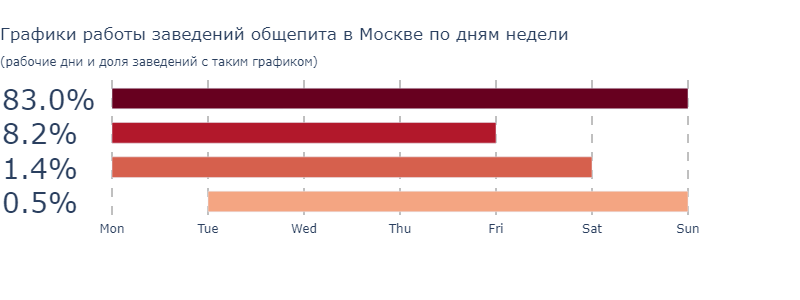

Большинство заведений — 88,6% — работают ежедневно, существенно менее распространены графики работы с выходными в субботу и воскресенье (8,7%), а также с одним выходным днем в воскресенье (1,5%). Процент заведений с выходным  в понедельник — очень мал, менее 1; остальные графики работы еще более редкие.

Посмотрим данные о времени открытия и закрытия заведений.

In [ ]:
# выборочные процентили по всем заведениям
data[['mo_start', 'mo_end',
      'tu_start', 'tu_end',
      'we_start', 'we_end',
      'th_start', 'th_end',
      'fr_start', 'fr_end',
      'sa_start', 'sa_end',
      'su_start', 'su_end']].describe().loc[['25%', '50%', '75%']]

mo_start  mo_end  tu_start  tu_end  we_start  we_end  th_start  th_end  \
25%      8.00   21.00      8.00   21.00      8.00   21.00      8.00   21.00   
50%     10.00   22.00     10.00   22.00     10.00   22.00     10.00   22.00   
75%     11.00   23.00     11.00   23.00     11.00   23.00     11.00   23.00   

     fr_start  fr_end  sa_start  sa_end  su_start  su_end  
25%      8.00   21.00      9.00   21.00      9.00   22.00  
50%     10.00   22.00     10.00   22.00     10.00   22.75  
75%     11.00   23.00     11.00   23.00     11.00   24.00

In [ ]:
# выборочные процентили по некруглосуточным заведениям
data[data['is_24/7']==False][['mo_start', 'mo_end',
      'tu_start', 'tu_end',
      'we_start', 'we_end',
      'th_start', 'th_end',
      'fr_start', 'fr_end',
      'sa_start', 'sa_end',
      'su_start', 'su_end']].describe().loc[['25%', '50%', '75%']]

mo_start  mo_end  tu_start  tu_end  we_start  we_end  th_start  th_end  \
25%      8.00   21.00      8.50   21.00      8.50   21.00      8.50   21.00   
50%     10.00   22.00     10.00   22.00     10.00   22.00     10.00   22.00   
75%     11.00   23.00     11.00   23.00     11.00   23.00     11.00   23.00   

     fr_start  fr_end  sa_start  sa_end  su_start  su_end  
25%      8.50   20.00      9.00   21.00      9.00   21.00  
50%     10.00   22.00     10.00   22.00     10.00   22.00  
75%     11.00   23.00     11.00   23.00     11.00   23.00

Исключая заведения, которые работают 24/7:
- половина заведений к 10 утра уже работают, 25% — в будние дни открываются не позже 9-00;
- 25% заведений закрываются к 21-00, в пятницу — 20-00; половина заведений работают как минимум до 22-00, 25% — открыты до 23-00 и позже.

### Средняя стоимость заказа в рублях
Проанализируем среднюю стоимость заказа в рублях.

In [ ]:
#по сырым данным
g_count_category(False,
                 data.groupby('district')['middle_avg_bill']\
                     .agg(['median']).sort_values(by='median'),
                 'Средний чек (медиана) <br>'+\
                 'в заведениях общественного питания Москвы по округам',
                 'Медиана',
                 data['middle_avg_bill'].median())

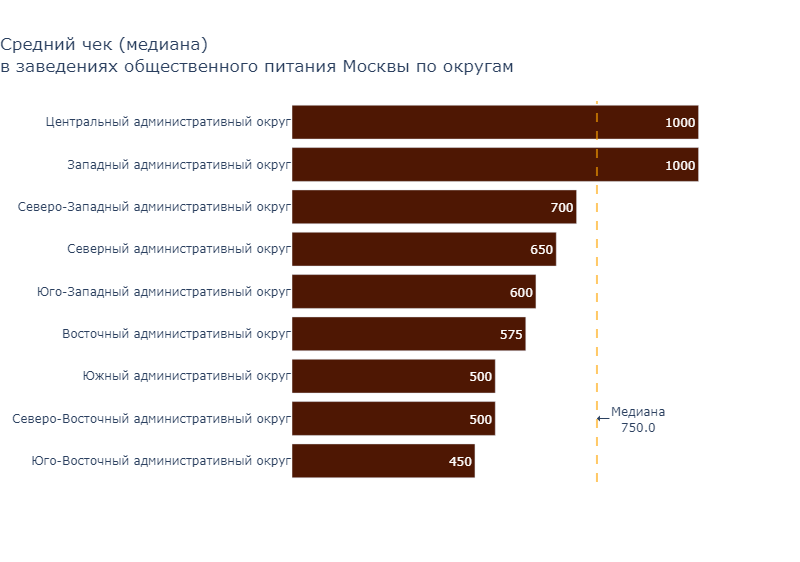

In [ ]:
#по очищенным данным (без 5% аномальных значений)
g_count_category(False,
                 data.query(filter_bill).groupby('dist')['middle_avg_bill']\
                 .agg(['median']).sort_values(by='median'),
                 'Средний чек (медиана) <br>'+\
                 'в заведениях общественного питания Москвы по округам',
                 'Медиана',
                 data.query(filter_bill)['middle_avg_bill'].median(),
                 i_height=50*9,
                 i_width=600)

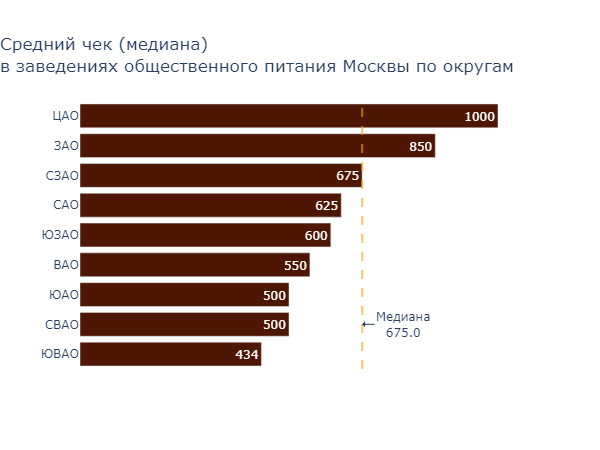

В округах медианное значение оценки среднего чека варьируется от 434-450 (ЮВАО) до 1000  р. (ЦАО и ЗАО). Медиана по всем заведениям общепита — 675-750 р.

Создадим фоновую картограмму с медианными значениями оценки среднего чека для каждого района, по "очищенным" данным, т.е. исключая аномально высокие цены в 5% заведениях.

In [ ]:
map_district_msk(
    data_map = data.query(filter_bill).groupby('district')['middle_avg_bill']\
                                      .agg(['median']).reset_index(),
    parameter = 'median',
    title_legend = 'Медианное значение оценки среднего чека по округам')

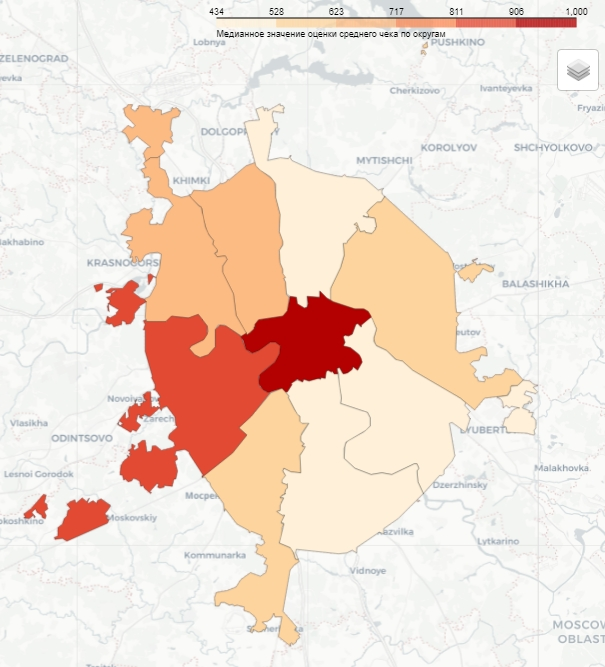

Карта иллюстрирует ранее выявленные закономерности: самый высокий средний чек в двух районах — ЦАО и ЗАО, низкий в трех — ЮАО,  СВАО, ЮВАО.

По приведенным данным сложно судить о зависимостти цен от удаленности от центра. Построим диаграмму рассеивания по координатам точек, размер маркера и цвет поставим в засимости от среднего чека в заведении.

In [ ]:
# Диаграмма рассеивания - расположение точек по координатам
fig = px.scatter(data.query(filter_bill),
                 x="lng", y="lat",
                 color="middle_avg_bill",
                 size='middle_avg_bill',
                 width = 1320, height = 800,
                 color_continuous_scale=px.colors.sequential.Inferno)

# добавим линии по координатам центра Москвы
fig.add_shape(
        type='line',
        line_color='black',
        line_width=1,
        opacity=0.6,
        line_dash='dash',
        x0=moscow_lng,
        x1=moscow_lng,
        y0=data.query(filter_bill)["lat"].min(),
        y1=data.query(filter_bill)["lat"].max(),
        )

fig.add_shape(
        type='line',
        line_color='black',
        line_width=1,
        opacity=0.6,
        line_dash='dash',
        y0=moscow_lat,
        y1=moscow_lat,
        x0=data.query(filter_bill)["lng"].min(),
        x1=data.query(filter_bill)["lng"].max(),
        )

fig.update_layout(
      title_text = 'Расположение заведений и средний чек<br>'+
                   '<sub>(размер и цвет маркера зависит от среднего чека)',
      title={'x':0})
fig.update_coloraxes(colorbar_title_text='Средний чек')
fig.show()

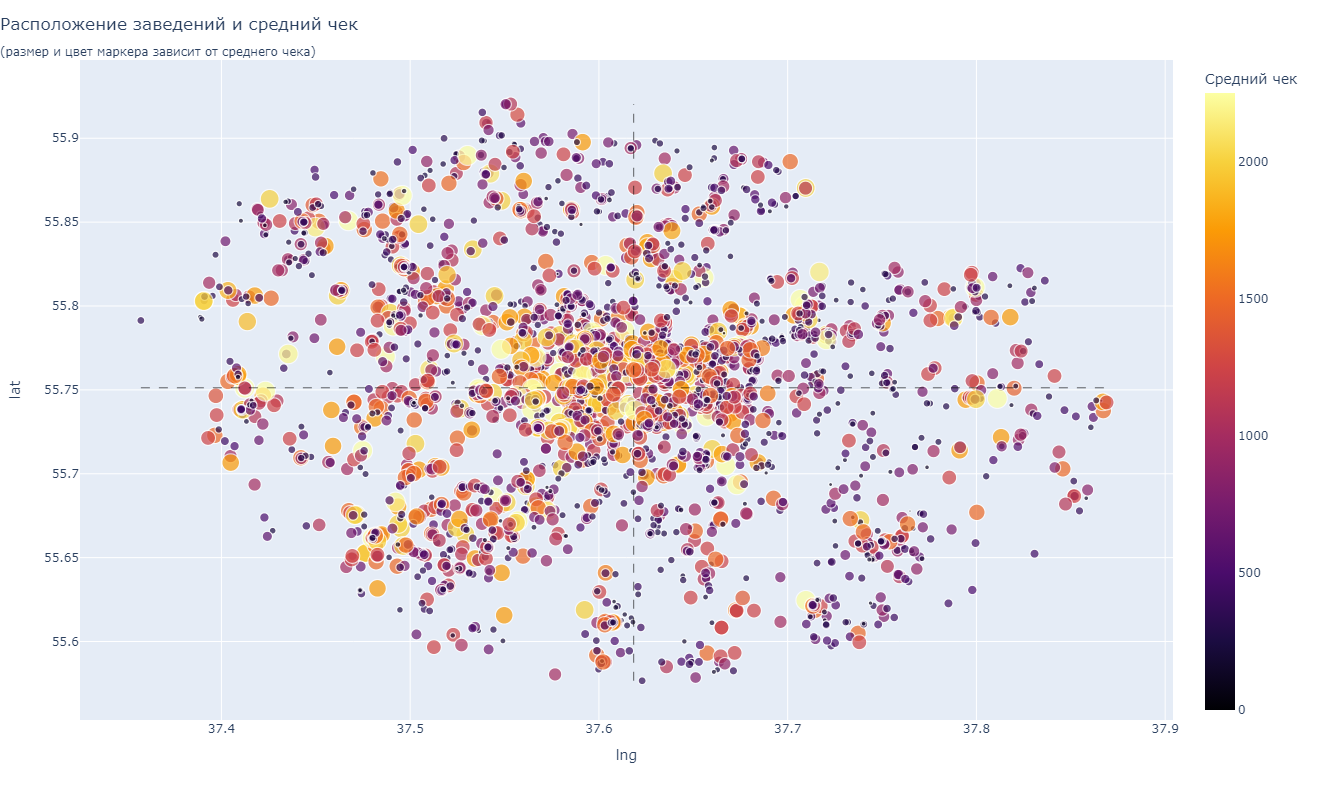

На диаграмме рассеивания явной зависимости среднего чека от удаленности от центра — не прослеживается.

Рассчитаем расстояние от цента москвы до заведения по координатам, используя формулу гаверсинусов, и проанализируем медианное значение среднего чека на каждый км удаленности от центра.

In [ ]:
# Функция для расчета расстояния от точки до центра Мск по формуле гаверсинусов
def distance(list):
  '''
  Функция принимает строку среза датасета с данными координат,
  возвращает расстояние до центра Мск, рассч. по формуле гаверсинусов
  '''

  moscow_lat, moscow_lng = 55.751244, 37.618423

  Lng1 = radians(moscow_lng)
  Lng2 = radians(list['lng'])
  Lat1 = radians(moscow_lat)
  Lat2 = radians(list['lat'])

  # используем формулу гаверсинусов
  D_Lng1 = Lng2 - Lng1
  D_Lat = Lat2 - Lat1
  P = sin(D_Lat / 2)**2 + cos(Lat1) * cos(Lat2) * sin(D_Lng1 / 2)**2

  Q = 2 * asin(sqrt(P))

  # радиус Земли, км
  R_km = 6371

  return(Q * R_km)


In [ ]:
# Новый столбец в датасете с расстоянием до центра,
# (для расчета использована функция distance)
data['distance'] = data[['lat', 'lng']].apply(distance, axis=1)
data['distance'] = round(data['distance'])

Рассчитаем коэффициент корреляции (Пирсона)

In [ ]:
# расчет корреляции, без аномалий среднего чека
data.query(filter_bill)[['distance', 'middle_avg_bill']].corr()

distance  middle_avg_bill
distance             1.00            -0.19
middle_avg_bill     -0.19             1.00

Есть слабая отрицательная связь между средним чеком и удаленностью до центра. Посмотрим данные на графиках, в т.ч. по округам.

In [ ]:
# Функция для построения столбчатых диаграмм "цена / расстояние до центра"

def bar_distance (data, parameter, for_title):
  '''
  Функция принимает датасет или его срез,
  parameter - по какой цене строить график: средняя цена, цена капучино
  for_title - уточнение для заголовка (см. title_text в fig.update_layout)

  Строит столбчатые диаграммы по всем данным и в разрезе округов
  '''

  # данные: барплот по общим данным
  df_dis = data.groupby('distance')[parameter].agg(['median']).dropna()
  values = df_dis['median']
  labels = df_dis.index

  # данные: барплот по округам
  df_dis2 = data.groupby(['dist', 'distance'])[parameter]\
                .agg(['median']).dropna().reset_index()
  values2 = df_dis2['median']
  labels2 = df_dis2['distance']

  # общая цветовая шкала
  range_color=[min(values.min(), values2.min()),
               max(values.max(), values2.max())]

  # барплот по общим данным

  fig = px.bar(
                  df_dis,
                  x=labels,
                  y=values,
                  color=values,
                  range_color=range_color,
                  text=values,
                  height = 400,
                  labels={'distance':' ',
                          'median':'средний чек',
                          'dist':'округ'},
                  color_continuous_scale=px.colors.sequential.Inferno
                  )

  fig.update_traces(textposition='inside', textfont_size=10)
  fig.update_layout(
        title_text = 'Средний чек '+for_title+\
                     ' в зависимости от удаленности до центра<br>'+\
                     '(по всем данным)',
        xaxis_title='удаленность от центра, км',
        yaxis_title='средний чек',
        title={'x':0})
  fig.show()


  df_dis2 = data.groupby(['dist', 'distance'])[parameter]\
                .agg(['median']).dropna().reset_index()

  fig = px.bar(
                df_dis2,
                x=labels2,
                y=values2,
                color=values2,
                range_color=range_color,
                facet_col='dist',
                height = 400,
                labels={'y':'средний чек', 'x':'км от центра', 'dist':'округ'},
                color_continuous_scale=px.colors.sequential.Inferno
              )

  fig.update_layout(
        title_text = 'Средний чек '+for_title+\
                     ' в зависимости от удаленности до центра<br>(по округам)',
        title={'x':0},
        margin= dict(t=120))

  fig.show()

In [ ]:
bar_distance (data = data.query(filter_bill),
              parameter = 'middle_avg_bill',
              for_title = 'в заведениях общепита Москвы')

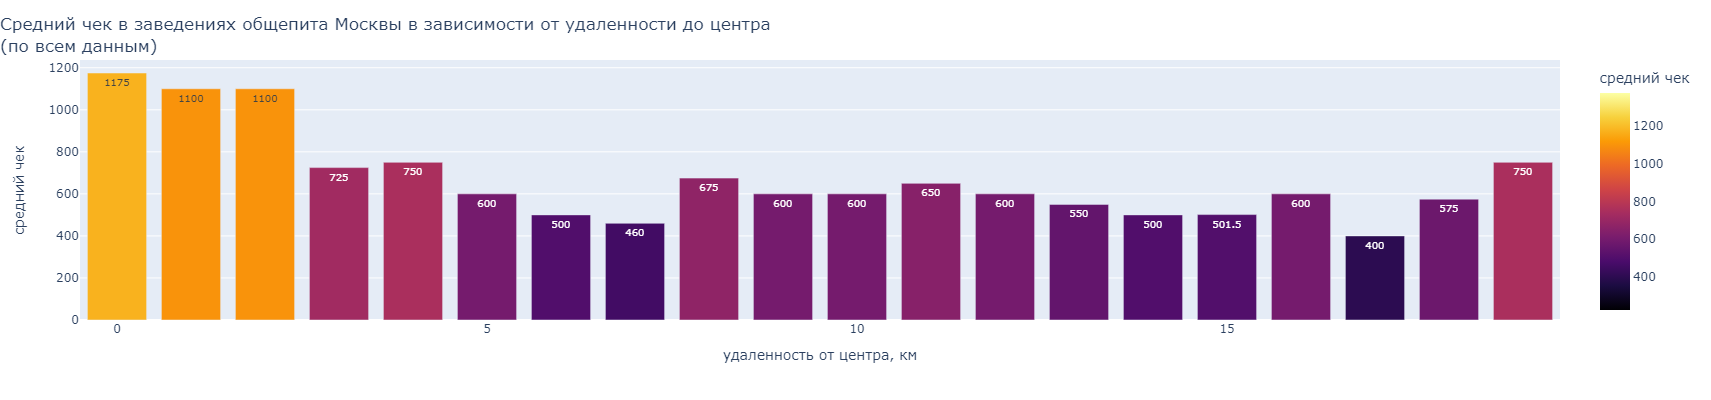

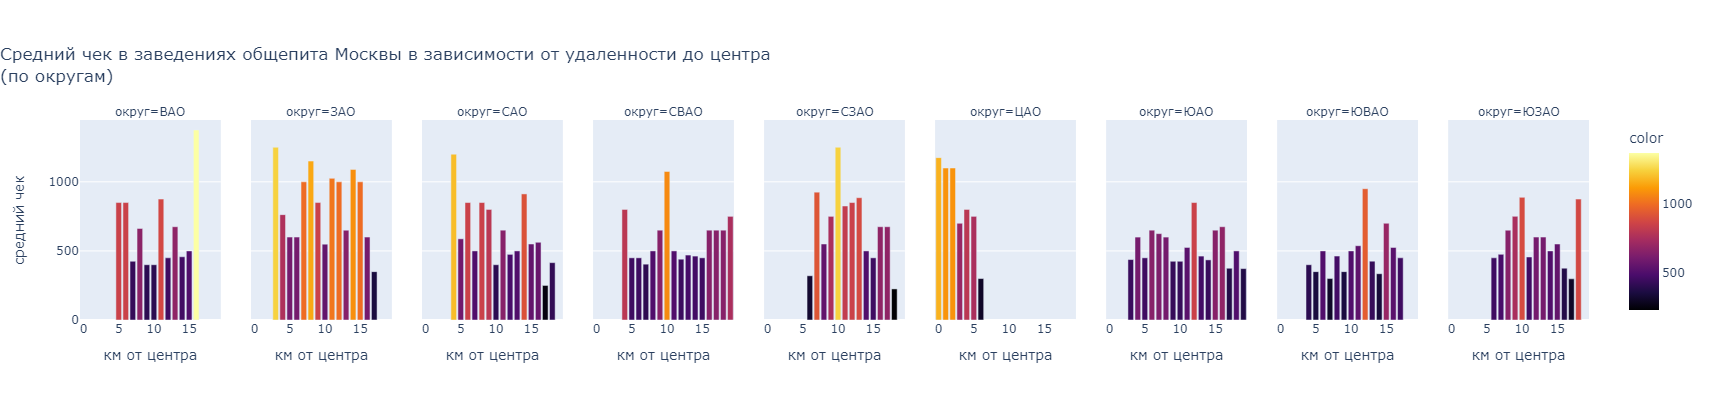

Коэффициент корреляции (-0,16) показывает слабую отрицательную связь между средним чеком и удаленностью до центра. Само наличие обратной корреляции — логично: в центре цены выше, "слабая" связь объясняется наличием других весомых факторов, в том числе неравномерностью развития районов. Более явная зависимость — в ЦАО.

### Итоги анализа рынка заведений общепита

**В Москве на момент проведения исследования насчитывается более 8,3 тыс. заведений общественного питания**. Больше всего кафе (2377 заведения / 28,3%), кофейни (1413 / 16,8%) — на третьем месте после ресторанов (2040 / 24,3%). Самые малочисленные категории — столовая и булочная — менее 4% каждая.


**Среднее количество посадочных мест** (медиана) в заведениях общепита в Москве — 70. Среди категорий наибольшее количество посадочных мест в ресторанах и барах/пабах — 80; в кофейнях — 70 (замыкают ТОП-4); минимум — в булочных (48-49).

**В общем количестве заведений — доля сетевых составляет чуть более 38%**, т.е. несетевых больше. В разрезе категорий: булочные чаще сетевые (61,3%), пиццерий и кофеен почти равное соотношение сетевых и несетевых с небольшим перевесом первых (52,2% сетевых пиццерий, 51% сетевых кофеен), в остальных категориях доля несетевых выше.

**Лидер ТОПа сетевых заведений по количеству точек в Москве — Шоколадница**. Для ТОП-15 характерен большой разброс количества точек сетей: выделяется на первом месте Шоколадница — 120 точек, в 2,7 раза больше, чем медиана по ТОП-15. Далее идут — пять сетей: Домино'с Пицца, Додо Пицца, One Price Coffee, Яндекс Лавка, Cofix — с количеством точек от 65 до 76. У остальных сетей из ТОПа количество точек не превышает 50, замыкает ТОП-15 "Му-му" (27 точек).

Медианные значения по ТОП-15 по показателям: количество посадочных мест, оценка среднего чека, оценка стоимости чашки капучино и рейтинг — немного ниже медианных значений по сравнению со всеми сетевыми и со всеми заведениями общепита. Медианное значения рейтинга у всех 4 и выше.

**Большинство (91%) заведений из ТОП-15 сетевых относятся к категориям: кофейни, рестораны, пиццерии, кафе**. Треть из 15 крупнейших сетей — кофейни.

Сетевые заведения из ТОПа чаще расположены в ЦАО. Но можно отметить исключения:
 - Домино'с Пицца, Додо Пицца, Яндекс Лавка — больше точек расположены не в ЦАО, что видимо, объясняется большой долей продаж с доставкой;
 - Теремок, Чайхана, Буханка — также приоритетное расположение не в ЦАО, скорее всего, из-за ориентира на более экономичный класс заведений.

В датасете представлены данные по девяти округам Москвы (нет данных по Зеленоградскому, Троицкому, Новомосковскому).

**Количество заведений в ЦАО значительно превышает показатели других округов: здесь расположено 2239 точек, или 26,7% от общего числа**. Минимум заведений общепита — в СЗАО: 409 точек, менее 5%.

«Топовые» категории заведений по округам (составляющие 20% и более всех точек в округе):
 - ЦАО — рестораны, кафе;
 - САО — кафе, кофейни, рестораны;
 -	Остальные округа — кафе, рестораны.

Больше всего кофеен — в ЦАО: здесь находится почти каждая третья кофейня (30,2%), также ЦАО выделяется и в других популярных категориях заведений: рестораны (32,8% всех ресторанов в ЦАО), бары / пабы (почти половина - 47,6% всех баров Мск находятся в ЦАО); при этом доля баров/пабов в самом ЦАО — 16,2% — значительно превышает этот показатель по другим округам.

**Средний рейтинг** разных категорий заведений отличается незначительно: +/- 0,2 пункта (4.2-4.4 из 5). Можно выделить бары/пабы — кроме самой высокого медианного рейтинга среди категорий (4,4), здесь максимальные оценки доходят до 5.0, 75% оценок выше 4.3, 25% оценок выше 4.6.

Самые низкие оценки у заведений быстрого питания — одна из самых низких медиан среди категория (4.2), минимальные оценки (без учета выбросов) доходят до 3.3, нижняя граница 75% оценок 3.9 (для сравнения у пиццерий этот показатель находится на 4.2).

Среди округов в лидерах опять ЦАО со средним рейтингом 4.4, в большинстве округов средний рейтинг 4.3, немного меньше — 4.2 — рейтинги в СВАО и ЮВАО.

**На ТОП-15 улиц по количеству заведений расположено 1238 точки общепита**, или 14,7% - т.е. каждое седьмое заведение находится на улице из ТОП-15. Самое большое количество точек на проспекте Мира - 183, замыкают топ Пятницкая улица и Алтуфьевское шоссе - здесь по 47 заведений. В топ ожидаемо попали большие, оживленные улицы.

Улиц с одной точкой общепита — 485 (5,7% от всего числа заведений). Такие улицы присутствуют во всех девяти округах, больше всего в ЦАО. Как правило, это небольшие улицы и переулки, чаще всего на них расположены кафе.

**Графики работы заведний**
 * 9,3% заведений работают ежедневно и круглосуточно.
 * Большинство заведений — 88,6% (включая 24/7) — работают ежедневно, существенно менее распространены графики работы с выходными в субботу и воскресенье (8,7%), а также с одним выходным днем в воскресенье (1,5%).

 Процент заведений с выходным в понедельник — очень мал, менее 1; остальные графики работы еще более редкие.

 * Время работы, исключая заведения, которые работают 24/7:
  *	половина заведений к 10 утра уже работают, 25% — в будние дни открываются не позже 9-00;
  *	25% заведений закрываются к 21-00, в пятницу — 20-00; половина заведений работают как минимум до 22-00, 25% — открыты до 23-00 и позже.


**Средний чек** (медианное значение) в округах  варьируется от 434-450 (ЮВАО) до 1000 р. (ЦАО и ЗАО). Медиана по всем заведениям общепита — 675-750 р.

Коэффициент корреляции (-0,16) показывает слабую отрицательную связь между средним чеком и удаленностью до центра. Само наличие обратной корреляции — логично: в центре цены выше, "слабая" связь объясняется наличием других весомых факторов, например, разных районов. Более явная зависимость — в ЦАО.

<a id="num4"></a>
## Анализ сегмента коффеен

По результатам анализа рынка заведений общепита можно отметить:
 * количество кофеен в Москве — 1413 точек, или 16.83% всех заведений общепита. Кофейни по количеству точек заимают третье место среди рассматриваемых категорий заведений (больше только ресторанов и кафе);
 * 50,96% кофеен — сетевые;
 * среднее количество посадочных мест в кофейнях — 70, что соответствует среднему значения по всем заведениям общепита в целом.

In [ ]:
g_count_category(True,
                 data.query('category == "кофейня"').groupby('dist')['name']\
                     .agg(['count']).sort_values(by='count'),
                 'Кофейни Москвы по округам<br>'+\
                 '(количество заведений и доля от общего числа в %)')

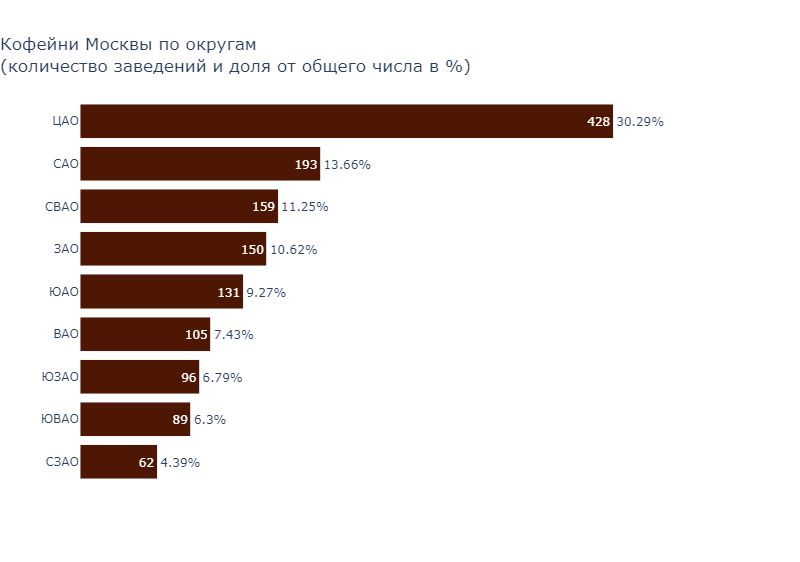

In [ ]:
g_count_category(False,
                 data.query('category == "кофейня"').groupby('dist')['seats']\
                     .agg(['median']).sort_values(by='median'),
                 'Кофейни Москвы по округам<br>'+\
                 '(среднее количество посадочных мест)',
                 'Медиана',
                 data.query('category == "кофейня"')['seats'].median(),
                 alert = 'ЦАО', i_height=50*9, i_width=600)

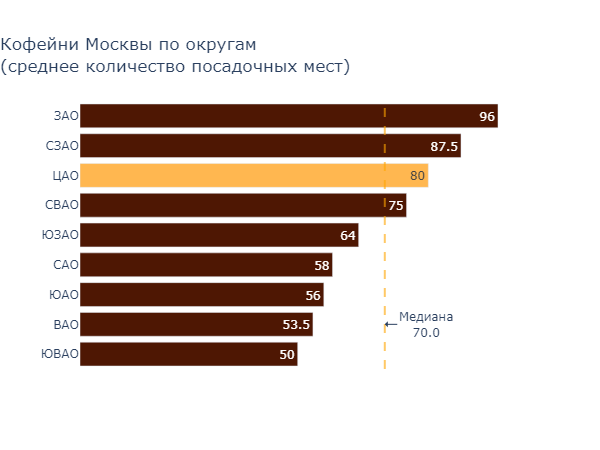

Большинство кофеен — 428, или 30.29% — расположены в ЦАО. На втором месте со значительным отставанием САО — 193 кофейни, или 13.66%.

Среднее количество посадочных мест по округам отличается: самое большое в ЗАО (96), в ТОП-3 также вошли СЗАО (87-88) и ЦАО (80).

In [ ]:
# рейтинг по округам
rating_chart(data.query('category == "кофейня"'), 'dist', "Средний рейтинг кофеин Москвы<br>по округам")

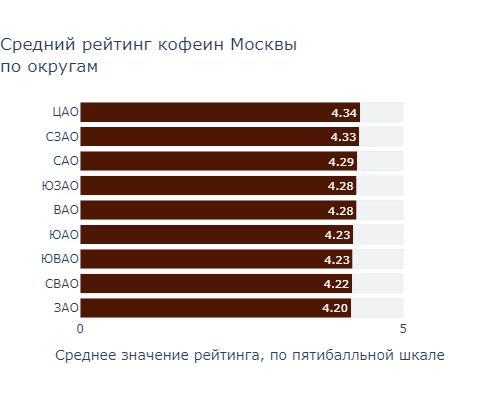

Средний рейтинг кофеен по округам — 4.3, за исключением ЗАО — 4.2.

In [ ]:
# доля круглосуточных кофеен

pie_chart(data_chart=data[(~data['hours'].isna()) &
                          (data['category']== 'кофейня')],
          alert_col = 'is_24/7',
          alert = True,
          maintitle="Доля кофеин, работающих 24/7",
          subtitle = 'заведений работают<br>ежедневно <br>и круглосуточно',
          label_alert = '24/7')

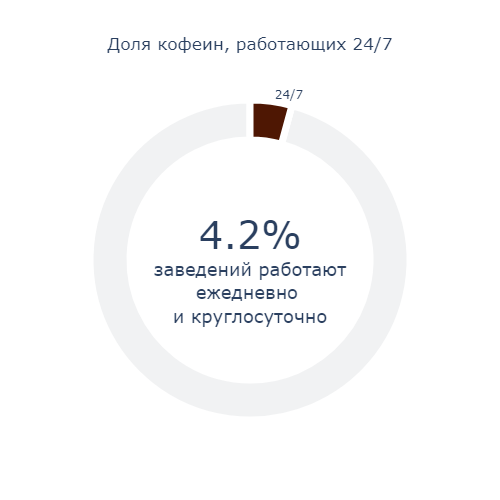

In [ ]:
work_days_chart(data.query('category == "кофейня"'),
                4,
                cart_title='Графики работы кофеен Москвы по дням недели')

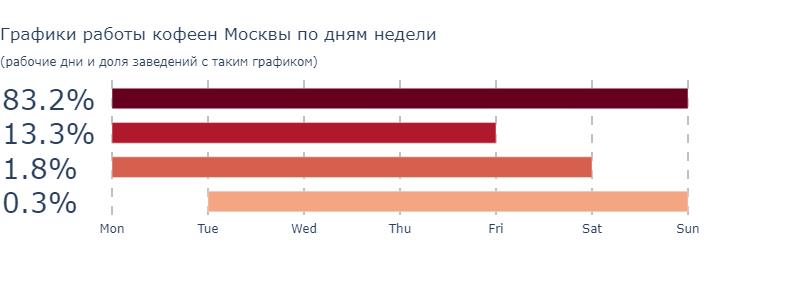

In [ ]:
# выборочные процентили по некруглосуточным заведениям
data[data['is_24/7']== False].query('category =="кофейня"')[list_day_start_off]\
                             .describe().loc[['25%', '50%', '75%']]

mo_start  mo_end  tu_start  tu_end  we_start  we_end  th_start  th_end  \
25%      8.00   20.00      8.00   20.00      8.00   20.00      8.00   20.00   
50%      8.00   22.00      8.00   22.00      8.00   22.00      8.00   22.00   
75%      9.00   22.00      9.00   22.00      9.00   22.00      9.00   22.00   

     fr_start  fr_end  sa_start  sa_end  su_start  su_end  
25%      8.00   20.00      8.00   21.00      8.00   21.00  
50%      8.00   22.00      9.00   22.00      9.00   22.00  
75%      9.00   22.00     10.00   22.00     10.00   22.00

Только 4,2% кофеен работают ежедневно и круглосуточно.
Большинство кофеен — 83.2% (включая 24/7) — работают ежедневно, 13.3% кофеен работают с понедельника по пятницу; остальные графики работы не распространены.

Время работы, исключая кофейни, которые работают 24/7:
 *	половина заведений в будние дни к 8 утра уже работают, 25% — открываются не позже 8-00 в том числе и в субботу и воскресенье;
 *	75% кофеен работают как минимум до 22-00, 25% — закрываются к 20-00 в будни, в выходные — 21-00.


In [ ]:
# График средней стоимости чашки капучино
g_count_category(
    False,
    data.query('category == "кофейня"')\
        .groupby('dist')['middle_coffee_cup']\
        .agg(['median']).sort_values(by='median'),
    'Средняя стомость (медиана) чашки капучино <br>'+\
    'в кофейнях Москвы по округам',
    'Медиана',
    data.query('category == "кофейня"')['middle_coffee_cup'].median(),
    i_height=50*9,
    i_width=600)

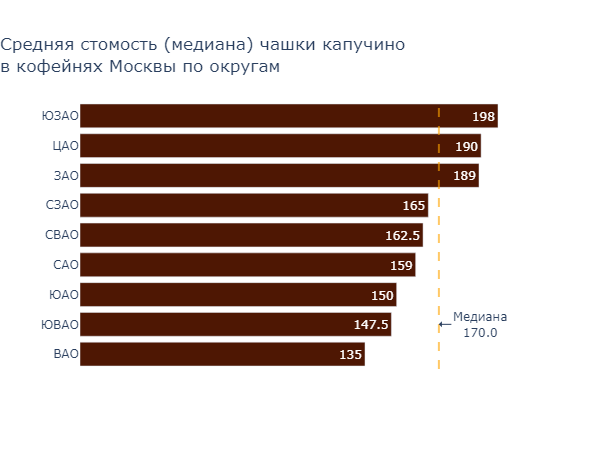

In [ ]:
# средние цены по округам на карте
map_district_msk(
    data_map = data.query('category == "кофейня"')\
                   .groupby('district')['middle_coffee_cup']\
                   .agg(['median']).reset_index(),
    parameter = 'median',
    title_legend = 'Медианное значение цены одной чашки капучино по округам')


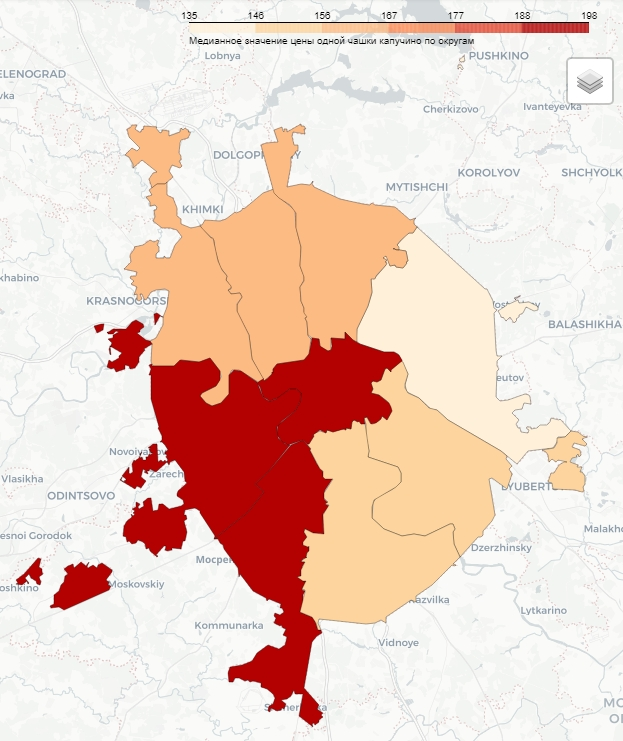

Медианное значение цены одной чашки капучино — 170 р. В трех округах: ЮЗАО, ЦАО, ЗАО этот показатель выше и составляет 189-198 р.

Посмотрим цены подробнее

In [ ]:
# гистограмма
df = data.query('category == "кофейня" & middle_coffee_cup < 500')
fig = px.histogram(df, x="middle_coffee_cup", nbins=18, width=800,
                   title='Гистограмма средней цены одной чашки капучино <br>'+\
                         'по количеству заведений'
                )
fig.show()

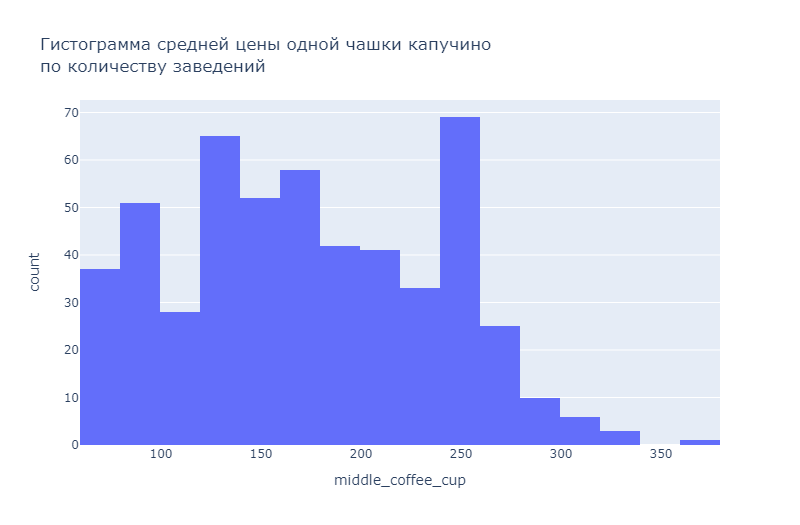

In [ ]:
# посмотрим "ящик с усами"

data_price=data.query('category == "кофейня"')

fig = px.violin(data.query('category == "кофейня"'),
                y="middle_coffee_cup",
                width = 800,
                box=True,
                points='all',
                title='Гистограмма средней цены одной чашки капучино <br>'+\
                'по количеству заведений'
                )
fig.show()

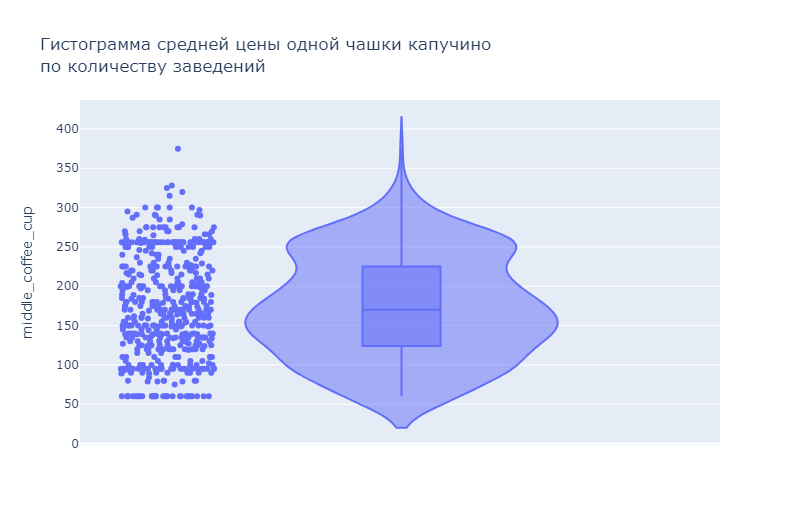

На диаграмме два явных и один небольшой пик, определим на их основе ценовые сегменты.

Т.о. на рынке кофеен Москвы можно выделить три сегмента:
 - более дешевый ценовой сегмент, где стоимость чашки капучино до 99 р.,
 - средний сегмент — от 100 до 225 р.,
 - сегмент выше среднего — выше 225 р.


In [ ]:
cut_labels_4 = ['дешевле 100₽', '100—225₽', 'дороже 225₽']
cut_bins = [0, 99, 225, 1000]

data['cup_price'] = pd.cut(data['middle_coffee_cup'],
                       bins=cut_bins,
                       labels=cut_labels_4)

In [ ]:
data.groupby('cup_price').agg(count=('name','count'),
                              median_price=('middle_coffee_cup', 'median'))\
                         .reset_index()

cup_price  count  median_price
0  дешевле 100₽     89         89.00
1      100—225₽    320        160.00
2   дороже 225₽    126        256.00

In [ ]:
# Функция для построения кольцевой диаграммы по ценовым сегментам
def  f_cup_price(data):
  df_cup_price = data.groupby('cup_price')\
                     .agg(count=('name','count'),
                          median_price=('middle_coffee_cup', 'median'))\
                     .reset_index()

  # pie
  custom_order = ['дешевле 100₽' , '100—225₽' , 'дороже 225₽']

  fig = px.pie(df_cup_price,
              values='count',
              names='cup_price',
              category_orders = {'cup_price': custom_order},
              hole=0.75,
              color_discrete_sequence=px.colors.sequential.RdBu,
              title='Сегментация кофеен <br>по средней цене <br>'+\
                    'одной чашки капучино<br><sub>количество кофеен (доли, %)'
              )

  fig.update_traces(textposition='outside', textinfo='percent+label')
  fig.update_traces(marker=dict(line=dict(width=5, color='#ffffff')))

  fig.update_layout(showlegend=False,
                    title_x=0.5,
                    title_y=0.55,
                    height=600,
                    width=600,
                    font=dict(size=16)
                   )
  fig.show()

In [ ]:
f_cup_price(data)

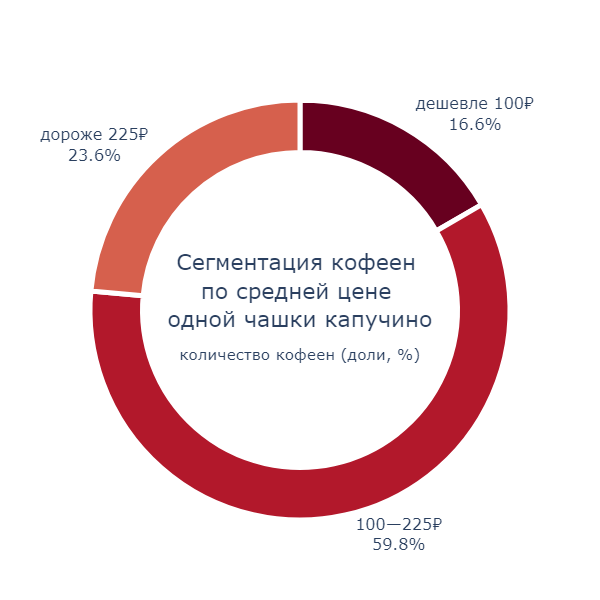

Почти 60% кофеен в среднем ценовом сегменте: цена чашки капучно от 100 до 225 р., в среднем  — 160 р. (медиана).


Посмотрим зависимость цены чашки капучино от удаленности от центра.

In [ ]:
bar_distance (data = data.query('category == "кофейня"'),
              parameter = 'middle_coffee_cup',
              for_title = 'в кофейнях Москвы')

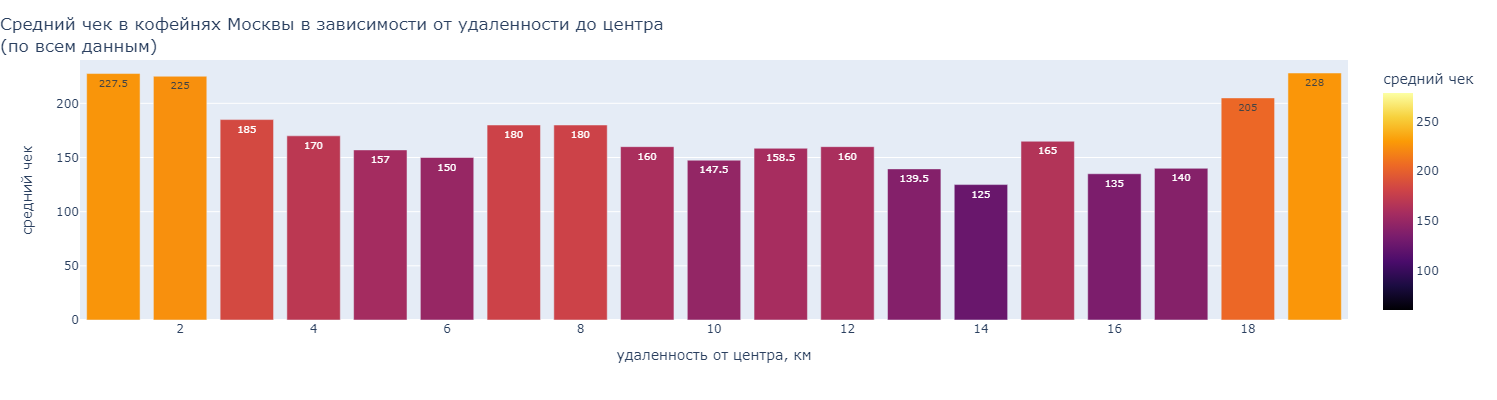

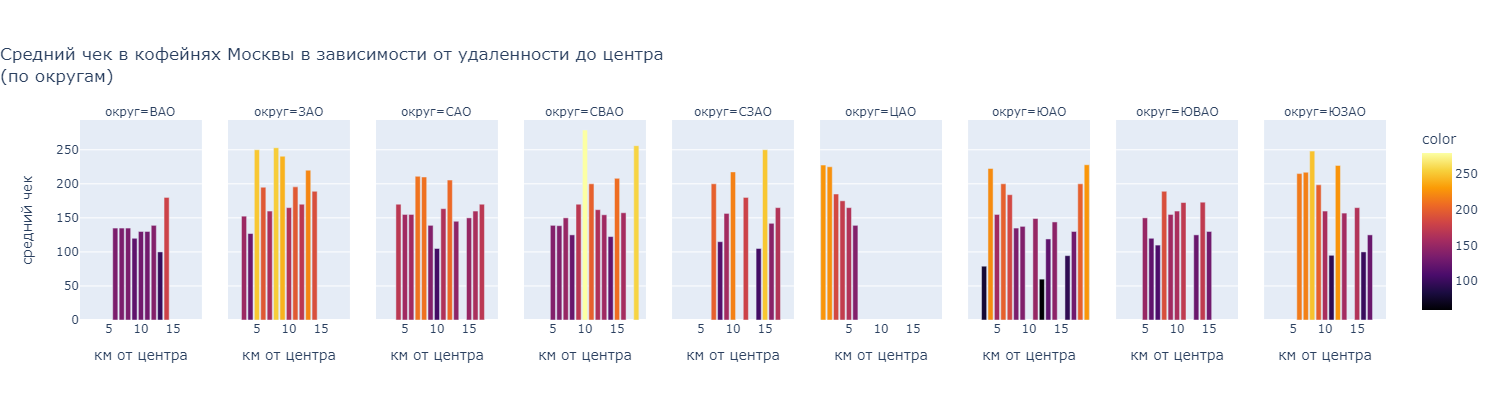

Явной зависимости на графиках не прослеживается, за исключением ЦАО.

In [ ]:
# рассчет корреляции
data.query('category == "кофейня" & middle_coffee_cup > 0')\
 [['distance', 'middle_coffee_cup']].corr()

distance  middle_coffee_cup
distance               1.00              -0.15
middle_coffee_cup     -0.15               1.00

In [ ]:
# рассчет корреляции по ЦАО
data.query('category == "кофейня" & middle_coffee_cup > 0 & dist == "ЦАО"' )\
 [['distance', 'middle_coffee_cup']].corr()

distance  middle_coffee_cup
distance               1.00              -0.22
middle_coffee_cup     -0.22               1.00

Коэффициент корреляции (-0,15) показывает слабую отрицательную связь между средней ценой чашки капучино и удаленностью от центра. Выше корреляция в ЦАО.

### Итоги анализа сегмента кофеен

 * **Количество кофеен в Москве — 1,4 тыс.**, или 16.83% всех заведений общепита. Кофейни по количеству точек занимают третье место среди рассматриваемых категорий (больше только ресторанов и кафе).

 * **50,96% кофеен — сетевые.**

 * **Больше всего кофеен расположены в ЦАО** — 428, или 30.29% от общего количества кофеен. На втором месте со значительным отставанием САО — 193 кофейни, или 13.66%.
 * **Среднее количество посадочных мест в кофейнях — 70**, что соответствует среднему значения по всем заведениям общепита в целом. Однако по округам данный показатель различен: максимум в ЗАО (96 посадочных мест), в ТОП-3 также вошли СЗАО (87-88) и ЦАО (80).
 * **Средний рейтинг кофеен по округам — 4.3, за исключением ЗАО — 4.2**.
 * **График работы:**
   * Только 4,2% кофеен работают ежедневно и круглосуточно.
   * Большинство кофеен — 83.2% (включая 24/7) — работают ежедневно, 13.3% кофеен работают с понедельника по пятницу; остальные графики работы встречаются редко.
   * Время работы, исключая кофейни, которые работают 24/7:

       половина заведений в будние дни к 8 утра уже работают, 25% — открываются не позже 8-00 в том числе и в субботу и воскресенье;

       75% кофеен работают как минимум до 22-00, 25% — закрываются к 20-00 в будни, в выходные — 21-00.
 * **Среднее значение цены одной чашки капучино — 170 р.**(медиана). В трех округах: ЮЗАО, ЦАО, ЗАО этот показатель выше и составляет 189-198 р.; в шести округах значение – ниже среднего.

 На рынке кофеен Москвы можно выделить три сегмента:
  * более дешевый ценовой сегмент, где стоимость чашки капучино до 99 р.,
  *	средний сегмент — от 100 до 225 р.
  * сегмент выше среднего — выше 225 р.

 Почти 60% кофеен в среднем ценовом сегменте.

 Зависимость цены от удаленности от центра — в целом слабая, хотя в ЦАО прослеживается сильнее.


<a id="num5"></a>
## Рекомендации для открытия кофейни

Сделаем сводную таблицу с показателями по округам

In [ ]:
df_coffee = data[data['category']=='кофейня'].groupby('dist')\
                .agg(total_count=('name', 'count'),
                      median_seats=('seats', 'median'),
                      median_coffee_cup=('middle_coffee_cup', 'median'),
                      median_rating=('rating', 'median')
                    ).sort_values(by='total_count', ascending=False)

df_coffee

total_count  median_seats  median_coffee_cup  median_rating
dist                                                             
ЦАО           428         80.00             190.00           4.30
САО           193         58.00             159.00           4.30
СВАО          159         75.00             162.50           4.30
ЗАО           150         96.00             189.00           4.20
ЮАО           131         56.00             150.00           4.30
ВАО           105         53.50             135.00           4.30
ЮЗАО           96         64.00             198.00           4.30
ЮВАО           89         50.00             147.50           4.30
СЗАО           62         87.50             165.00           4.30

In [ ]:
df_coffee = df_coffee.join(data[data['middle_coffee_cup'] > 0 ].groupby('dist')\
                           .agg(all_price=('name', 'count')))
df_coffee

total_count  median_seats  median_coffee_cup  median_rating  all_price
dist                                                                        
ЦАО           428         80.00             190.00           4.30        166
САО           193         58.00             159.00           4.30         77
СВАО          159         75.00             162.50           4.30         60
ЗАО           150         96.00             189.00           4.20         50
ЮАО           131         56.00             150.00           4.30         46
ВАО           105         53.50             135.00           4.30         42
ЮЗАО           96         64.00             198.00           4.30         35
ЮВАО           89         50.00             147.50           4.30         35
СЗАО           62         87.50             165.00           4.30         24

In [ ]:
# Основные показатели:кол-во заведений, кол-во кафе, кол-во мест,
#    средняя цена капучино, средний рейтинг

# Данные по округам: кол-во кофеин, ср.кол-во мест, ср.цена капучино, ср.рейтинг
df_coffee = data[data['category']=='кофейня'].groupby('dist')\
                .agg(total_count=('name', 'count'),
                      median_seats=('seats', 'median'),
                      median_coffee_cup=('middle_coffee_cup', 'median'),
                      mean_rating=('rating', 'mean')
                    ).sort_values(by='total_count', ascending=False)

# Добавляем данные по общему кол-ву заведений общепита
df_coffee = df_coffee.join(data.groupby('dist').agg(all=('name', 'count')))

# Доля кофеин от общего кол-ва заведений общепита
df_coffee['coffee_%'] = df_coffee['total_count'] / df_coffee['all']

# Кол-во кофеин с ценами в сегменте 100—225₽
df_coffee = df_coffee.join(data[data['cup_price']== '100—225₽'].groupby('dist')\
                           .agg(middle_price=('name', 'count')))
# Всего кофеин, где определен ценовой сегмент
df_coffee = df_coffee.join(data[data['middle_coffee_cup'] > 0 ].groupby('dist')\
                           .agg(all_price=('name', 'count')))
# Доля кофеин, с ценами в сегменте 100—225₽
df_coffee['100—225₽_'] = df_coffee['middle_price'] / df_coffee['all_price']

# Доля сетевых
df_coffee['chain_'] = data[data['category']=='кофейня'].groupby('dist')\
                          .agg(chain_mean=('chain', 'mean'))

# Удалим ненужные столбцы
df_coffee.drop(columns=['all', 'middle_price', 'all_price'],
               axis=1,
               inplace=True)

# Переименуем столбцы
df_coffee = df_coffee.rename(columns={'total_count': 'Количество кофеен',
                                      'coffee_%': 'Доля кофеен',
                                      'chain_': 'Доля сетевых',
                                      'median_seats': 'Ср. кол-во мест',
                                      'median_coffee_cup'	: 'Ср. цена капучино',
                                      '100—225₽_'	: 'Сегмент 100—225₽',
                                      'mean_rating': 'Ср. рейтинг'})

# Сортируем
df_coffee = df_coffee.reindex(columns=['Количество кофеен',
                                       'Доля кофеен',
                                       'Доля сетевых',
                                       'Ср. кол-во мест',
                                       'Ср. цена капучино',
                                       'Сегмент 100—225₽',
                                       'Ср. рейтинг'])

df_coffee.index.name= None

# Форматирование таблицы
(df_coffee.style.format(formatter="{:.1f}")
                .format(formatter="{:.1%}", subset=['Доля сетевых',
                                                    'Доля кофеен',
                                                    'Сегмент 100—225₽'])
                .bar(subset=['Количество кофеен'], color='#ea9f97')
                .bar(subset=['Доля сетевых'], color='#a3acf7')
                .bar(subset=['Ср. цена капучино'], color='#72dbc5')
                .bar(subset=['Сегмент 100—225₽'], color='#c8a6f7')
                .set_caption('Сегмент кофеен: показатели по округам Москвы')
                 .set_table_styles([{'selector': 'caption',
                                     'props': [('font-size', '16px'),
                                               ('font-weight', 'bold')]}])
)

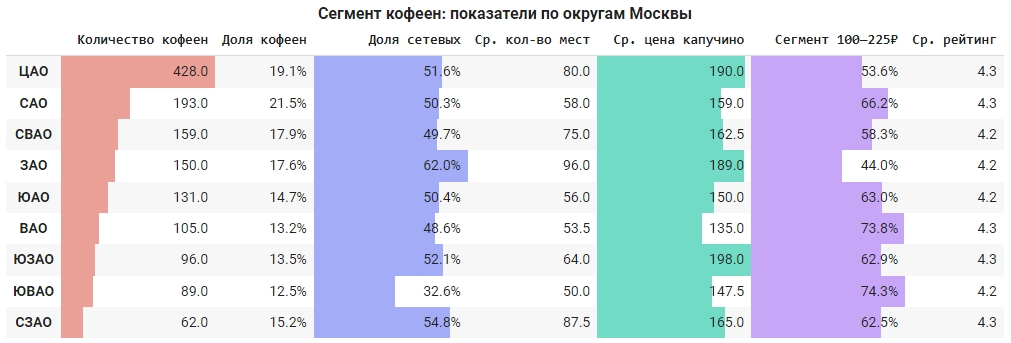

Если ориентироваться на количество действующих кофеен как показатель наличия соотвествующего спроса, то **для открытия кофейни стоит рассмотреть Центральный АО**. По сравнению с другими округами, здесь:
 - максимальное количество кофеен (показатель значительно выше других округов),
 - доля кофеен (%% от общего количества заведений общепита в округе) — одна из самых высоких, что, возможно, является показателем предпочтений посетителей и  выгодностью для бизнеса,
 - средняя цена одной чашки капучина — одна из самых высоких, но при этом доля среднего ценового сегмента остается на приемлемом уровне,
 - рейтинг — на уровне дргуих округов, при этом довольно высокий 4.3,
 - доля сетевых заведений — на среднем уровне.

**Ориентир для количества посадочных мест — в диапазоне 70-80** (медианное значение по Мск и по ЦАО).Отметим, что среднее количество посадочных мест — выше общей медианы. Возможно, открытие маленького заведения в ЦАО нерентабельно.




In [ ]:
# доли сегментов по цене
f_cup_price(data.query('dist == "ЦАО"'))

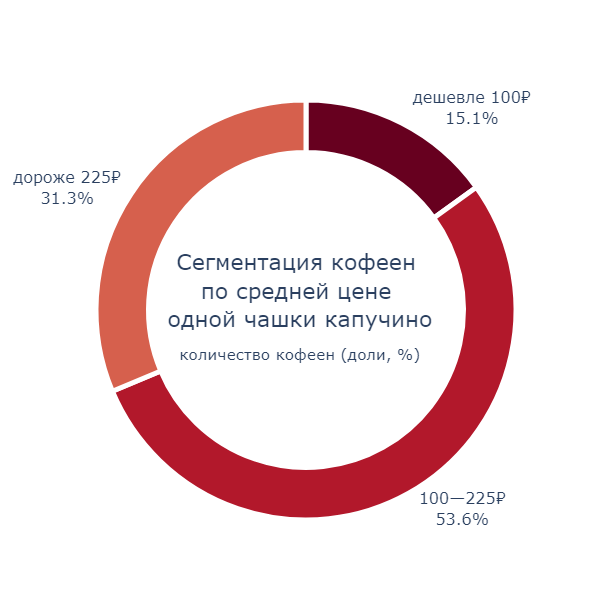

Поскольку в планируют открывать доступную кофейню, посмотрим распредление цен в среднем ценовом сегменте.

In [ ]:
# медиана в среднем ценовом сегменте
data.query('category == "кофейня" & dist == "ЦАО" & cup_price == "100—225₽"')\
 ['middle_coffee_cup'].median()

175.0

In [ ]:
# Срез по ценовому сегменту 100—225₽
df_100_225 = data.query('category == "кофейня" & '+
                        'dist == "ЦАО" & '+
                        'cup_price == "100—225₽"')

# Гистограмма по среднему ценовому сегменту

fig = go.Figure(data=[go.Histogram(x=df_100_225["middle_coffee_cup"])])

fig.update_traces(marker=dict(color=px.colors.sequential.RdBu[1],
                              line=dict(width=5, color='#ffffff')))

fig.update_layout({'plot_bgcolor': 'white',
                   'paper_bgcolor': 'white'},
                  height=400,
                  width=400,
                  title='Распределение средних цен одной чашки <br>'+\
                        'капучино в сегменте 100—225₽ ЦАО<br>'+\
                        '<sub>(по количеству кофеен)')

fig.update_xaxes(
  showline=True,
  linewidth=1,
  linecolor='black',
  title="Цена, ₽"
  )

fig.update_yaxes(
  showgrid=True,
  gridwidth=1,
  gridcolor='lightgray',
  )

fig.show()

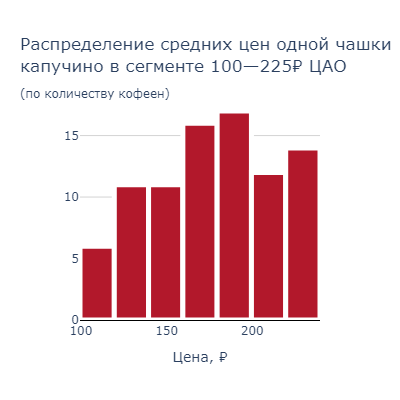

Для открытия доступной кофейни необходимо **ориентироваться на средний ценовой сегмент 100—225₽ за одну чашку капучино**. Самый частый вариант цены в данном сегменте находится в диапазоне 160—200₽, т.е. в среднем — 180₽.

Проанализируем графики работы кофеен в ЦАО.


In [ ]:
# доля круглосуточных кофеен в ЦАО

pie_chart(data_chart=data[(~data['hours'].isna()) &
                          (data['category']== 'кофейня') &
                          (data['dist']== 'ЦАО')],
          alert_col = 'is_24/7',
          alert = True,
          maintitle="Доля кофеин в ЦАО, работающих 24/7",
          subtitle = 'заведений работают<br>ежедневно <br>и круглосуточно',
          label_alert = '24/7')

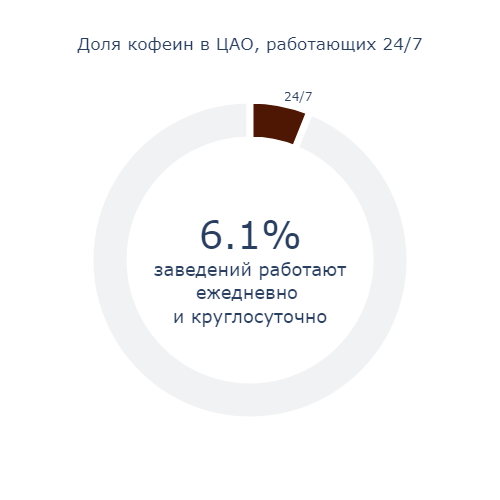

In [ ]:
#график работы
work_days_chart(data.query('category == "кофейня" & dist== "ЦАО"'),
                4,
                cart_title='Графики работы кофеен в ЦАО Москвы по дням недели')

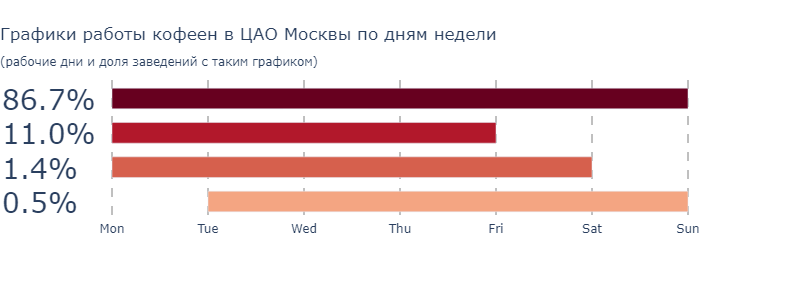

In [ ]:
# Время работы
# Выборочные процентили по некруглосуточным кофейням ЦАО
#   в зависимости от ценового сегмента

for s in ['дешевле 100₽', '100—225₽', 'дороже 225₽']:
  display(data[data['is_24/7']== False]\
              .query('category == "кофейня" & dist == "ЦАО" & cup_price == @s')\
              [list_day_start_off].describe().loc[['25%', '50%', '75%']]\
              .style.set_caption('Средняя стоимость чашки капучино: '+s)\
                    .set_table_styles([{'selector': 'caption',
                                        'props': [('font-size', '16px'),
                                                  ('font-weight', 'bold')]}]))

График работы кофеен ЦАО принципиально не отличается.

**Рекомендованный график работы : ежедневно,  c 8-00 до 21-00 в будни, с 9-00 до 21-00 — в субботу и воскресенье**. Такой график соответствует среднему времени открытия и закрытия кофеен в среднем ценовом сегменте. Дополнительно можно рассмотреть возможность работы до 22-00 (что соответствует более высокому ценовому сегменту, а также более ждешевому в субботу и воскресенье) и/или с 8-00 — в субботу и воскресенье (так работает более дешевый ценовой сегмент, возможно, рассчитанный на "кофе с собой" для людей, работающих в выходные).

### Summary по рекомендациям

Рекомендованные ориентировочные параметры для открытия новой кофейни:
 * округ: Центральный,
 * количество посадочных мест — в диапазоне 70-80,
 * средняя цена одной чашки капучино: диапазон 100—225₽, около 175₽,
 * график работы : ежедневно, c 8-00 до 21-00 в будни, с 9-00 до 21-00 — в субботу и воскресенье.

<a id="num6"></a>
## Презентация

[Ссылка на презентацию (pdf)](<https://drive.google.com/file/d/1oZGuyUqDXmkvyDpu0M8nBLABAPZuHHbI/view?usp=sharing>)